# Introduction
- identify ranges, outliers, trends, patterns, missing values (imputative, drop), categorization (for ML), encoding
- consider combining some features if they show similar trends as the target variable. Could be revealed using feature ranking too.

### Imports
Import libraries and write settings here.

In [1]:
import matplotlib 
# Specify renderer
# matplotlib.use('Agg')

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Boiler-plate settings for producing pub-quality figures
# 1 point = 1/72 inch
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
matplotlib.rcParams.update({'figure.figsize': (8, 5)    # inches
                            , 'font.size': 22      # points
                            , 'legend.fontsize': 16      # points
                            , 'lines.linewidth': 1.5       # points
                            , 'axes.linewidth': 1.5       # points
                            , 'text.usetex': True    # Use LaTeX to layout text
                            , 'font.family': "serif"  # Use serifed fonts
                            , 'xtick.major.size': 10     # length, points
                            , 'xtick.major.width': 1.5     # points
                            , 'xtick.minor.size': 6     # length, points
                            , 'xtick.minor.width': 1     # points
                            , 'ytick.major.size': 10     # length, points
                            , 'ytick.major.width': 1.5     # points
                            , 'ytick.minor.size': 6     # length, points
                            , "xtick.minor.visible": True
                            , "ytick.minor.visible": True
                            , 'font.weight': 'bold'
                            , 'ytick.minor.width': 1     # points
                            , 'font.serif': ("Times", "Palatino", "Computer Modern Roman", "New Century Schoolbook", "Bookman"), 'font.sans-serif': ("Helvetica", "Avant Garde", "Computer Modern Sans serif"), 'font.monospace': ("Courier", "Computer Modern Typewriter"), 'font.cursive': "Zapf Chancery"
                            })


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

In [3]:
# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

In [5]:
import sys
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp

# ML
import sklearn

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

#Set the display format to be scientific for ease of analysis
# pd.options.display.float_format = '{:,.2g}'.format

In [6]:
try: 
    import subprocess
    gitd = os.path.abspath(os.path.join(os.path.dirname(__file__),os.pardir))
    githash = subprocess.check_output('git --git-dir={0:s} --work-tree={1:s} '\
              'rev-parse HEAD'.format(gitd+'/.git',gitd),shell=True).rstrip()
except:
    githash = 'No repo found'

print(githash)

No repo found


In [7]:
%load_ext watermark
%watermark -v -h -n -g -m -p jupyerlab,numpy,scipy,sklearn,pandas,matplotlib

Fri Jun 26 2020 

CPython 3.7.6
IPython 7.13.0

jupyerlab not installed
numpy 1.18.1
scipy 1.4.1
sklearn 0.22.1
pandas 1.0.3
matplotlib 3.1.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
host name  : C02X61QTJHD5
Git hash   : 7f73a12f5a7f4485a31fed840a5d3dea75e02d0f


In [8]:
data = pd.read_table('../data/raw/breast-cancer-wisconsin.txt', delimiter=',', header=0)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   # Index                      15855 non-null  int64 
 1   ID                           15855 non-null  int64 
 2   Clump Thickness              15855 non-null  int64 
 3   Uniformity of Cell Size      15827 non-null  object
 4   Uniformity of Cell Shape     15827 non-null  object
 5   Marginal Adhesion            15827 non-null  object
 6   Single Epithelial Cell Size  15827 non-null  object
 7   Bare Nuclei                  15827 non-null  object
 8   Bland Chromatin              15827 non-null  object
 9   Normal Nucleoli              15827 non-null  object
 10  Mitoses                      15827 non-null  object
 11  Class                        15827 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


In [10]:
data.head()

,# Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


In [11]:
# Get number of unique entries in each column
object_nunique = list(map(lambda col: data[col].nunique(), data.columns))
d = dict(zip(data.columns, object_nunique))

# Print number of unique entries by each column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Class', 7),
 ('Mitoses', 14),
 ('Clump Thickness', 17),
 ('Uniformity of Cell Shape', 19),
 ('Single Epithelial Cell Size', 19),
 ('Bare Nuclei', 19),
 ('Bland Chromatin', 19),
 ('Marginal Adhesion', 20),
 ('Uniformity of Cell Size', 21),
 ('Normal Nucleoli', 22),
 ('ID', 666),
 ('# Index', 15855)]

In [12]:
# Drop duplicates based on ID number
df = data.drop_duplicates('ID')
print(df.ID.nunique(), len(df))

666 666


In [13]:
# missing val, imputate value?
df.isna().any()

# Index                        False
ID                             False
Clump Thickness                False
Uniformity of Cell Size        False
Uniformity of Cell Shape       False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                    False
Bland Chromatin                False
Normal Nucleoli                False
Mitoses                        False
Class                          False
dtype: bool

In [14]:
print("Calculate the % of missing values in each row")
df.isna().mean()

Calculate the % of missing values in each row


# Index                        0.0
ID                             0.0
Clump Thickness                0.0
Uniformity of Cell Size        0.0
Uniformity of Cell Shape       0.0
Marginal Adhesion              0.0
Single Epithelial Cell Size    0.0
Bare Nuclei                    0.0
Bland Chromatin                0.0
Normal Nucleoli                0.0
Mitoses                        0.0
Class                          0.0
dtype: float64

In [15]:
# replace colnames
print("Replace all spaces and convert to lower")
df.columns = df.columns.str.replace(" ", "").str.lower()

Replace all spaces and convert to lower


In [16]:
df.columns

Index(['#index', 'id', 'clumpthickness', 'uniformityofcellsize',
       'uniformityofcellshape', 'marginaladhesion', 'singleepithelialcellsize',
       'barenuclei', 'blandchromatin', 'normalnucleoli', 'mitoses', 'class'],
      dtype='object')

In [17]:
# drop the #index col
df.drop('#index', axis=1, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666 entries, 0 to 15779
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        666 non-null    int64 
 1   clumpthickness            666 non-null    int64 
 2   uniformityofcellsize      666 non-null    object
 3   uniformityofcellshape     666 non-null    object
 4   marginaladhesion          666 non-null    object
 5   singleepithelialcellsize  666 non-null    object
 6   barenuclei                666 non-null    object
 7   blandchromatin            666 non-null    object
 8   normalnucleoli            666 non-null    object
 9   mitoses                   666 non-null    object
 10  class                     666 non-null    object
dtypes: int64(2), object(9)
memory usage: 62.4+ KB


In [19]:
# cast type to numeric so we can plot distributions
df= df.apply(pd.to_numeric, errors="coerce")

df['class'] = df['class'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666 entries, 0 to 15779
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        666 non-null    int64  
 1   clumpthickness            666 non-null    int64  
 2   uniformityofcellsize      665 non-null    float64
 3   uniformityofcellshape     665 non-null    float64
 4   marginaladhesion          665 non-null    float64
 5   singleepithelialcellsize  665 non-null    float64
 6   barenuclei                649 non-null    float64
 7   blandchromatin            665 non-null    float64
 8   normalnucleoli            665 non-null    float64
 9   mitoses                   665 non-null    float64
 10  class                     665 non-null    object 
dtypes: float64(8), int64(2), object(1)
memory usage: 62.4+ KB


                id  clumpthickness  uniformityofcellsize  \
count       666.00          666.00                665.00   
mean    1387025.97            6.54                  4.93   
std     1858185.38           12.26                 11.24   
min       61634.00            1.00                  1.00   
25%      888257.50            2.00                  1.00   
50%     1174279.50            4.00                  1.00   
75%     1242192.75            7.00                  5.00   
max    13454352.00          100.00                100.00   

       uniformityofcellshape  marginaladhesion  singleepithelialcellsize  \
count                 665.00            665.00                    665.00   
mean                    4.74              4.32                      4.39   
std                     9.48              9.89                      7.32   
min                     1.00              1.00                      1.00   
25%                     1.00              1.00                      2.00   
50%

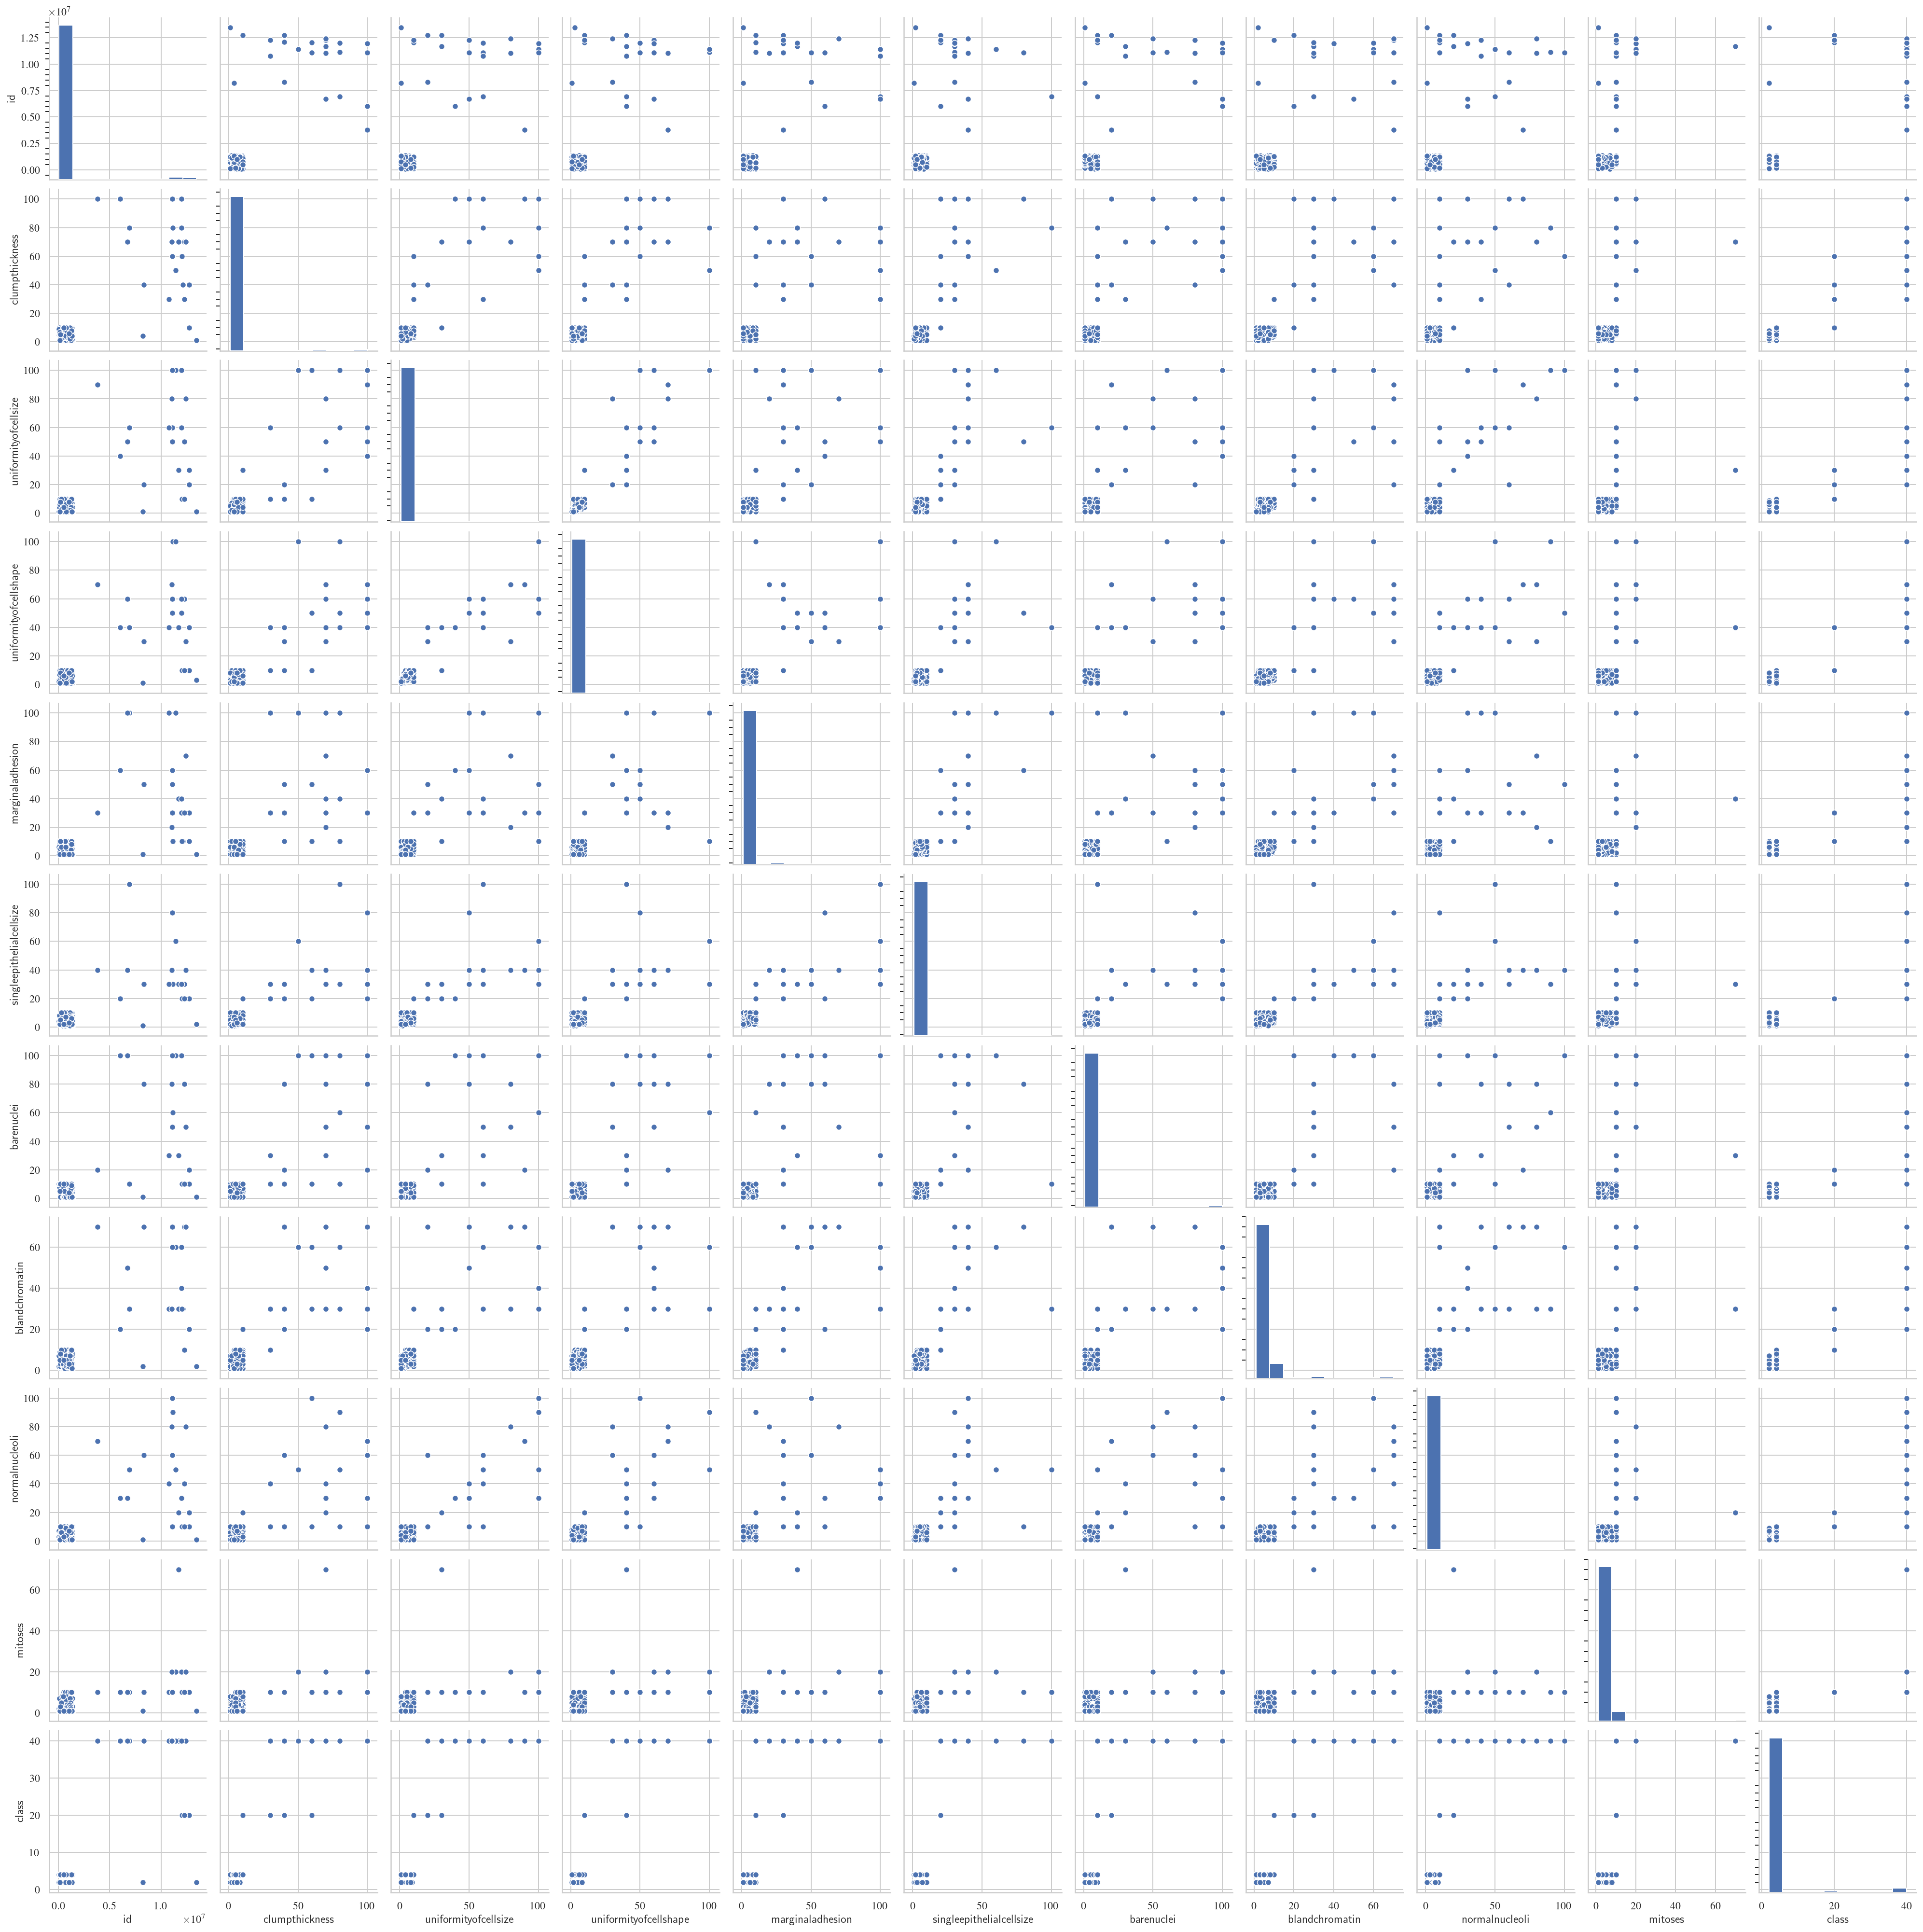

In [20]:
# identify ranges, outliers again
print(df.describe().round(2))

# find outliers, trends, patterns, plot histograms, correlation plots
sns.pairplot(df)
plt.show()



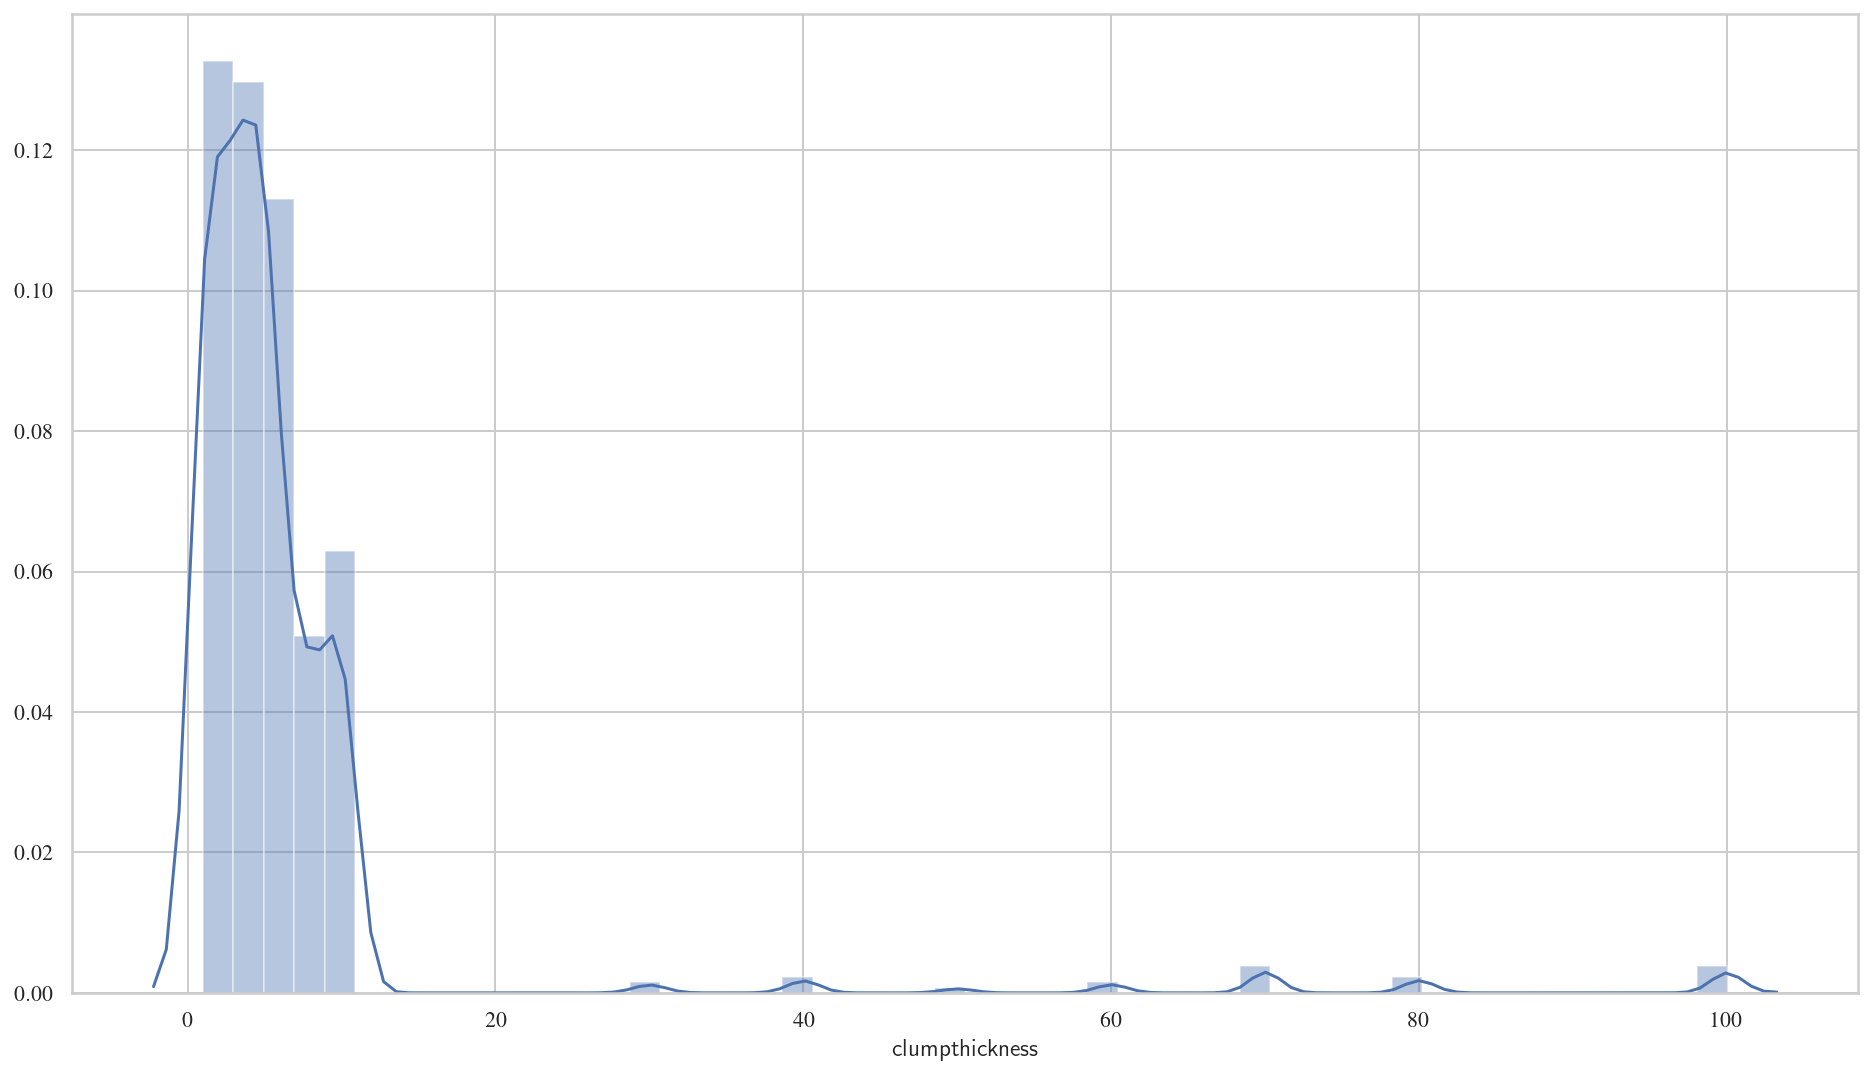

In [21]:
# hist plot
tmp = df.select_dtypes(exclude=['object'])
tmp = tmp.loc[:, tmp.columns != 'id']


sns.distplot(tmp.iloc[:, 0])
plt.show()


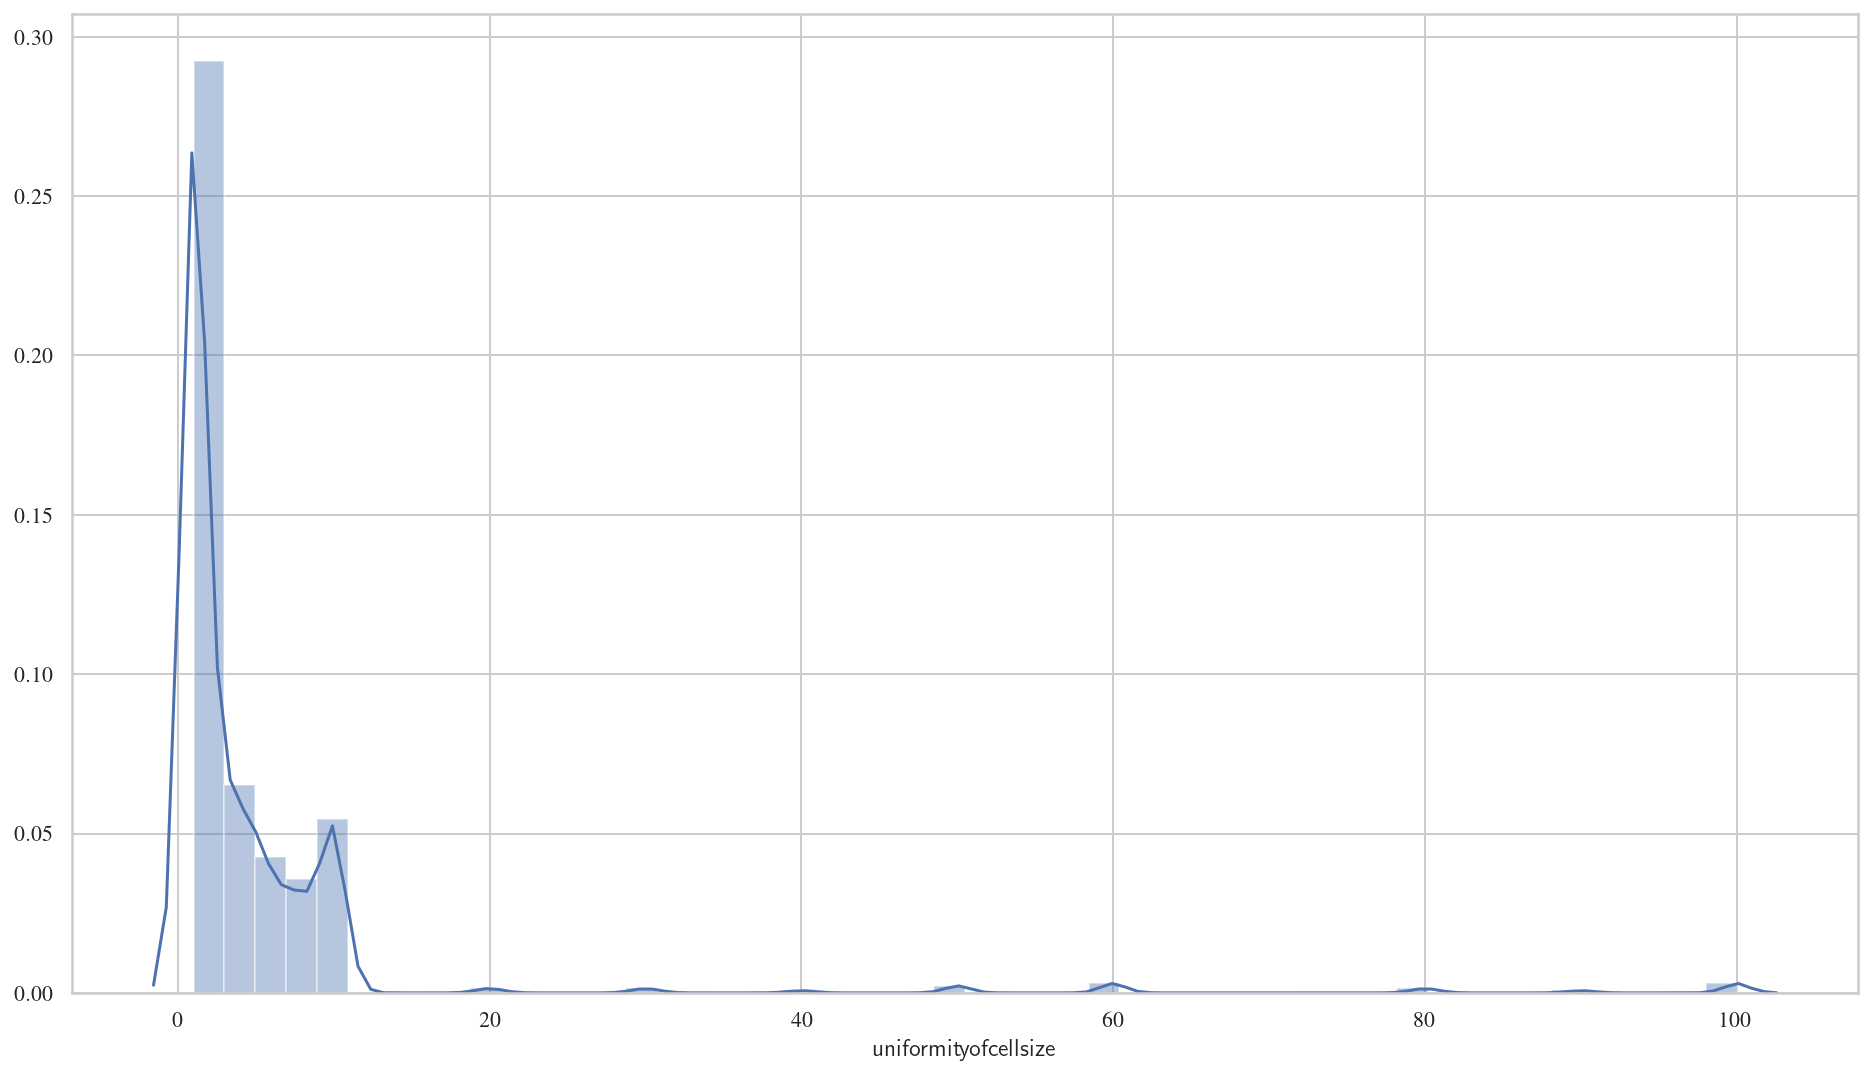

In [22]:
sns.distplot(tmp.iloc[:, 1])
plt.show()

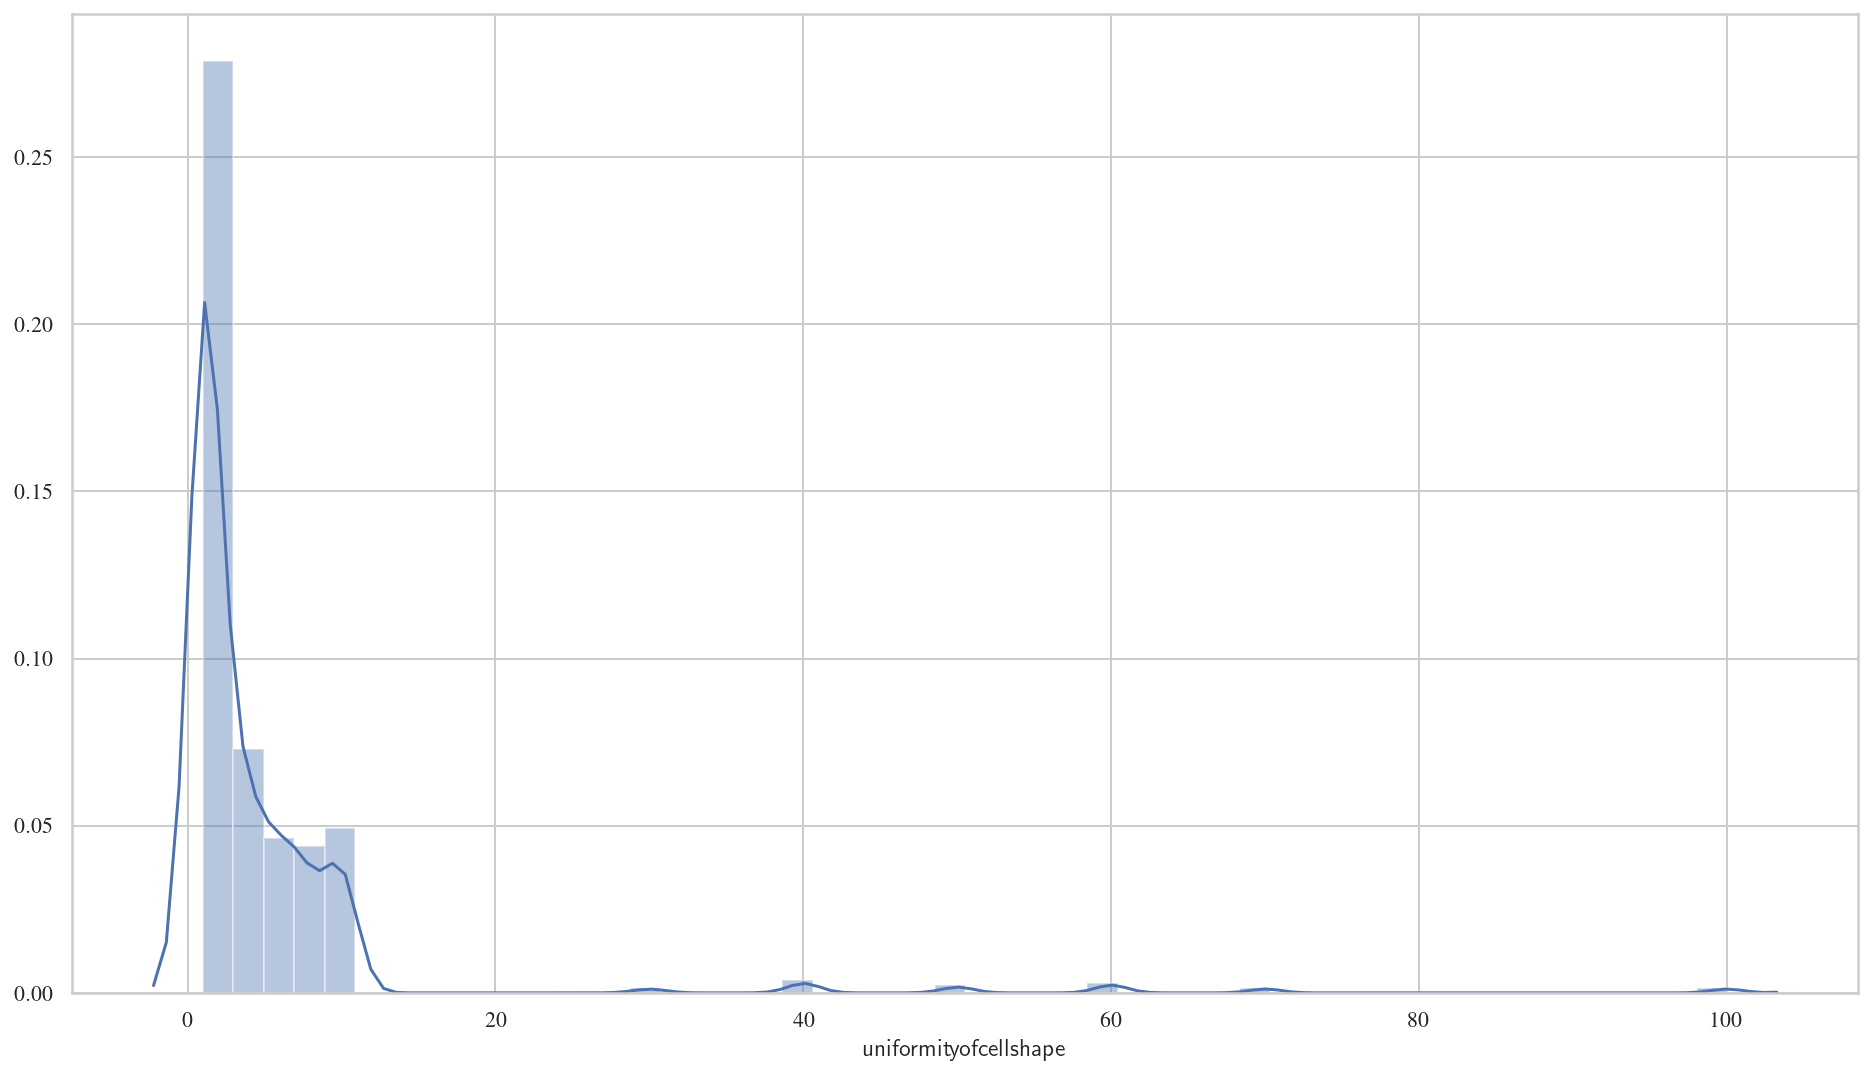

In [23]:
sns.distplot(tmp.iloc[:, 2])
plt.show()

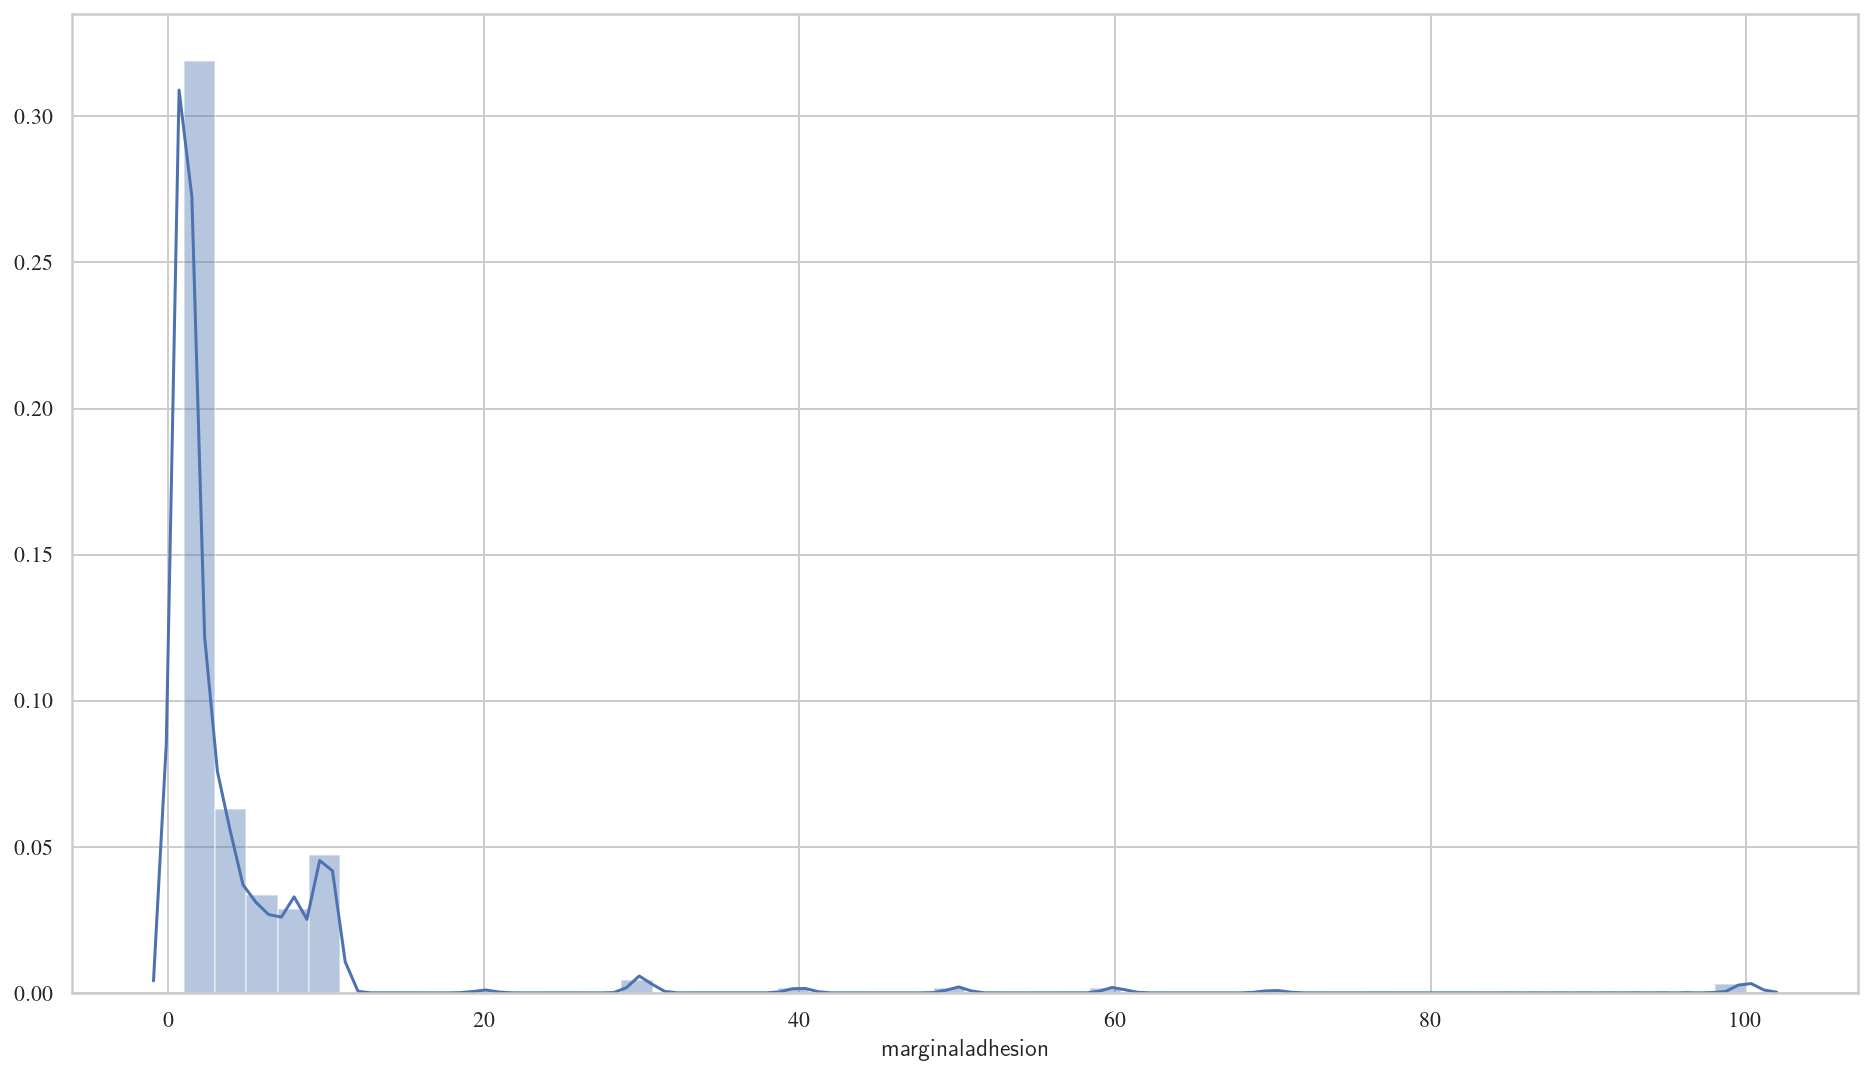

In [24]:
sns.distplot(tmp.iloc[:, 3])
plt.show()

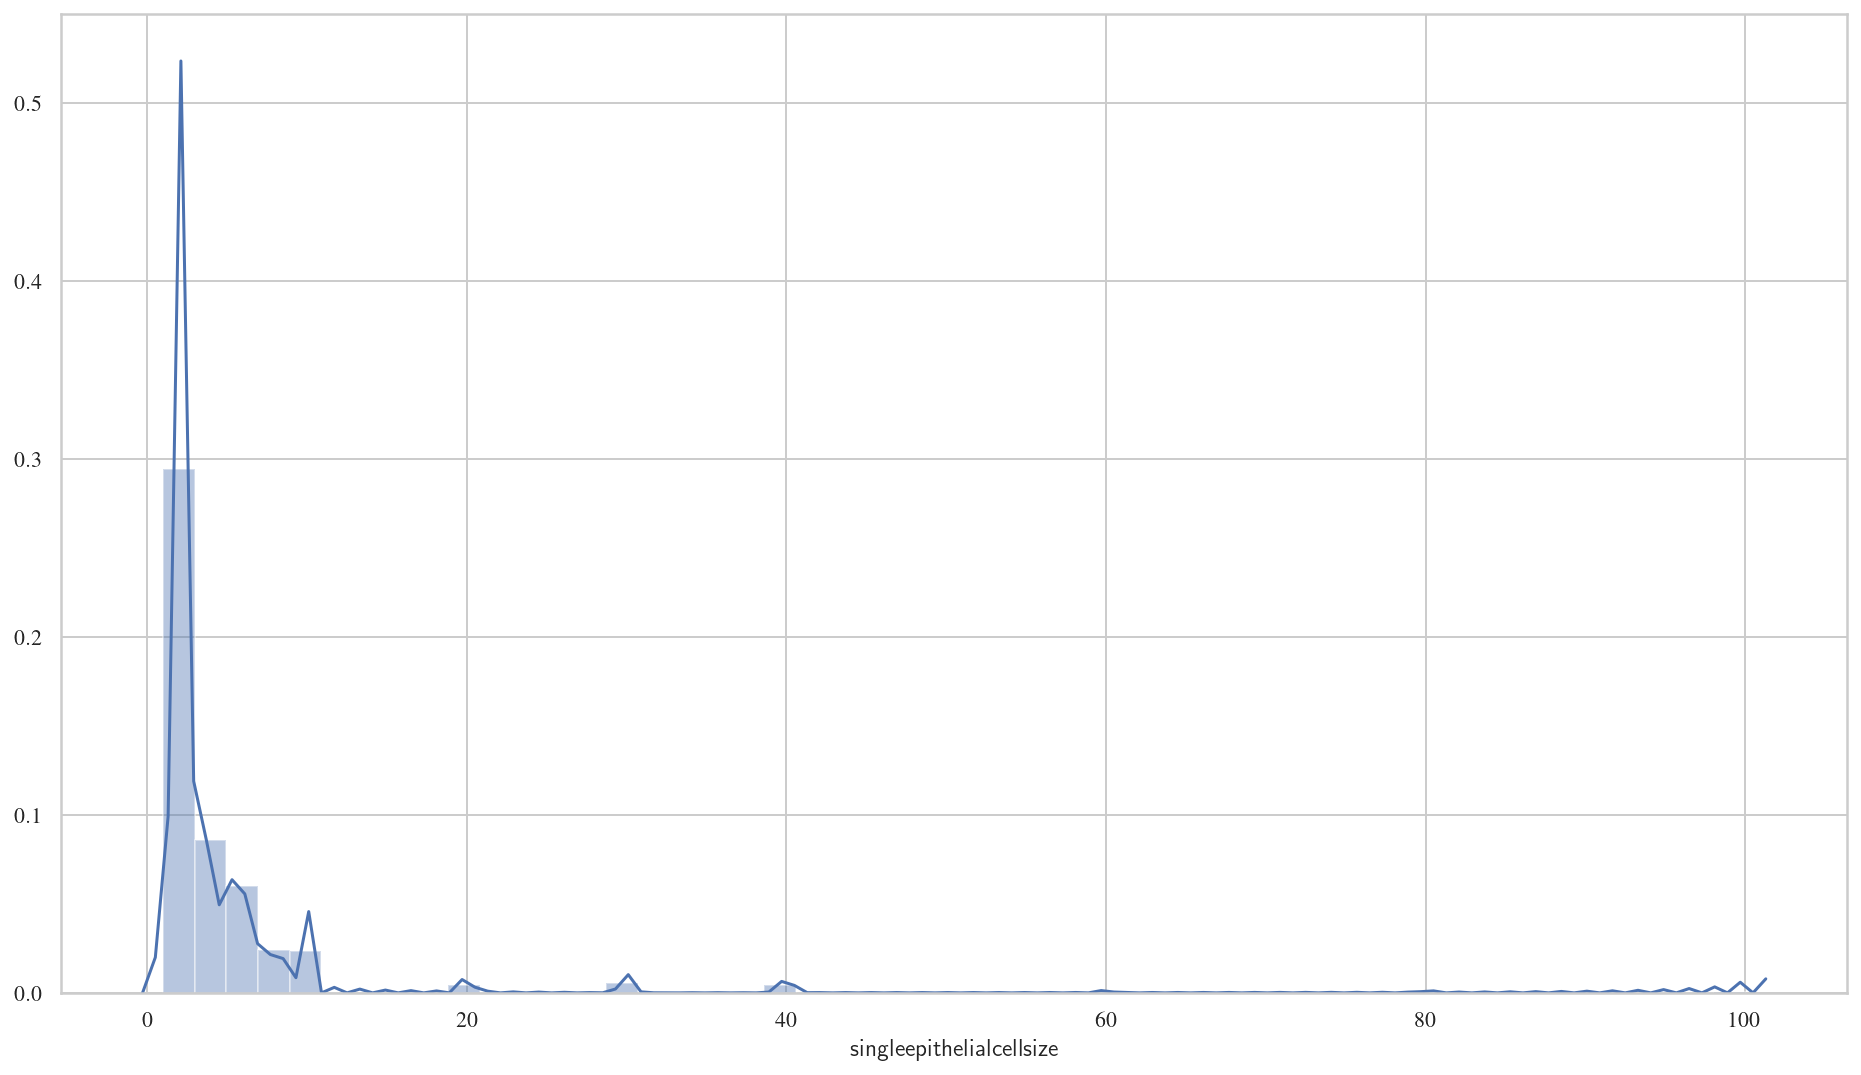

In [25]:
sns.distplot(tmp.iloc[:, 4])
plt.show()

In [26]:
df['class'].nunique(), df['class'].unique()

(4, array([4.0, 2.0, 40.0, 20.0, nan], dtype=object))

In [27]:
# Remove rows where class is not 4 or 2
df_clean = df.loc[df['class'].isin([4.0, 2.0])]

In [28]:
df_clean['class'].nunique(), df_clean['class'].unique()
df = df_clean

(2, array([4.0, 2.0], dtype=object))

4 = benign, 2 = malignant

In [29]:
df.columns

Index(['id', 'clumpthickness', 'uniformityofcellsize', 'uniformityofcellshape',
       'marginaladhesion', 'singleepithelialcellsize', 'barenuclei',
       'blandchromatin', 'normalnucleoli', 'mitoses', 'class'],
      dtype='object')

In [30]:
# Remove rows w/ values out of range of 1-10, as given as valid measurement
def minMax(x):
    return pd.Series(index=['min','max'], data=[x.min(),x.max()])
df[['clumpthickness', 'uniformityofcellsize', 'uniformityofcellshape',
       'marginaladhesion', 'singleepithelialcellsize', 'barenuclei',
       'blandchromatin', 'normalnucleoli', 'mitoses']].apply(minMax)



,clumpthickness,uniformityofcellsize,uniformityofcellshape,marginaladhesion,singleepithelialcellsize,barenuclei,blandchromatin,normalnucleoli,mitoses
min,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,clumpthickness,uniformityofcellsize,uniformityofcellshape,marginaladhesion,singleepithelialcellsize,barenuclei,blandchromatin,normalnucleoli,mitoses
clumpthickness,1.000000,0.642052,0.652375,0.481255,0.509358,0.591266,0.557842,0.530808,0.346563
uniformityofcellsize,0.642052,1.000000,0.902495,0.706964,0.741582,0.680889,0.752852,0.716864,0.453428
uniformityofcellshape,0.652375,0.902495,1.000000,0.682846,0.706131,0.701499,0.731330,0.714155,0.431793
marginaladhesion,0.481255,0.706964,0.682846,1.000000,0.597795,0.669054,0.663869,0.589972,0.405634
singleepithelialcellsize,0.509358,0.741582,0.706131,0.597795,1.000000,0.571159,0.612683,0.623235,0.483203
barenuclei,0.591266,0.680889,0.701499,0.669054,0.571159,1.000000,0.676897,0.571498,0.326556
blandchromatin,0.557842,0.752852,0.731330,0.663869,0.612683,0.676897,1.000000,0.658920,0.331846
normalnucleoli,0.530808,0.716864,0.714155,0.589972,0.623235,0.571498,0.658920,1.000000,0.417630
mitoses,0.346563,0.453428,0.431793,0.405634,0.483203,0.326556,0.331846,0.417630,1.000000


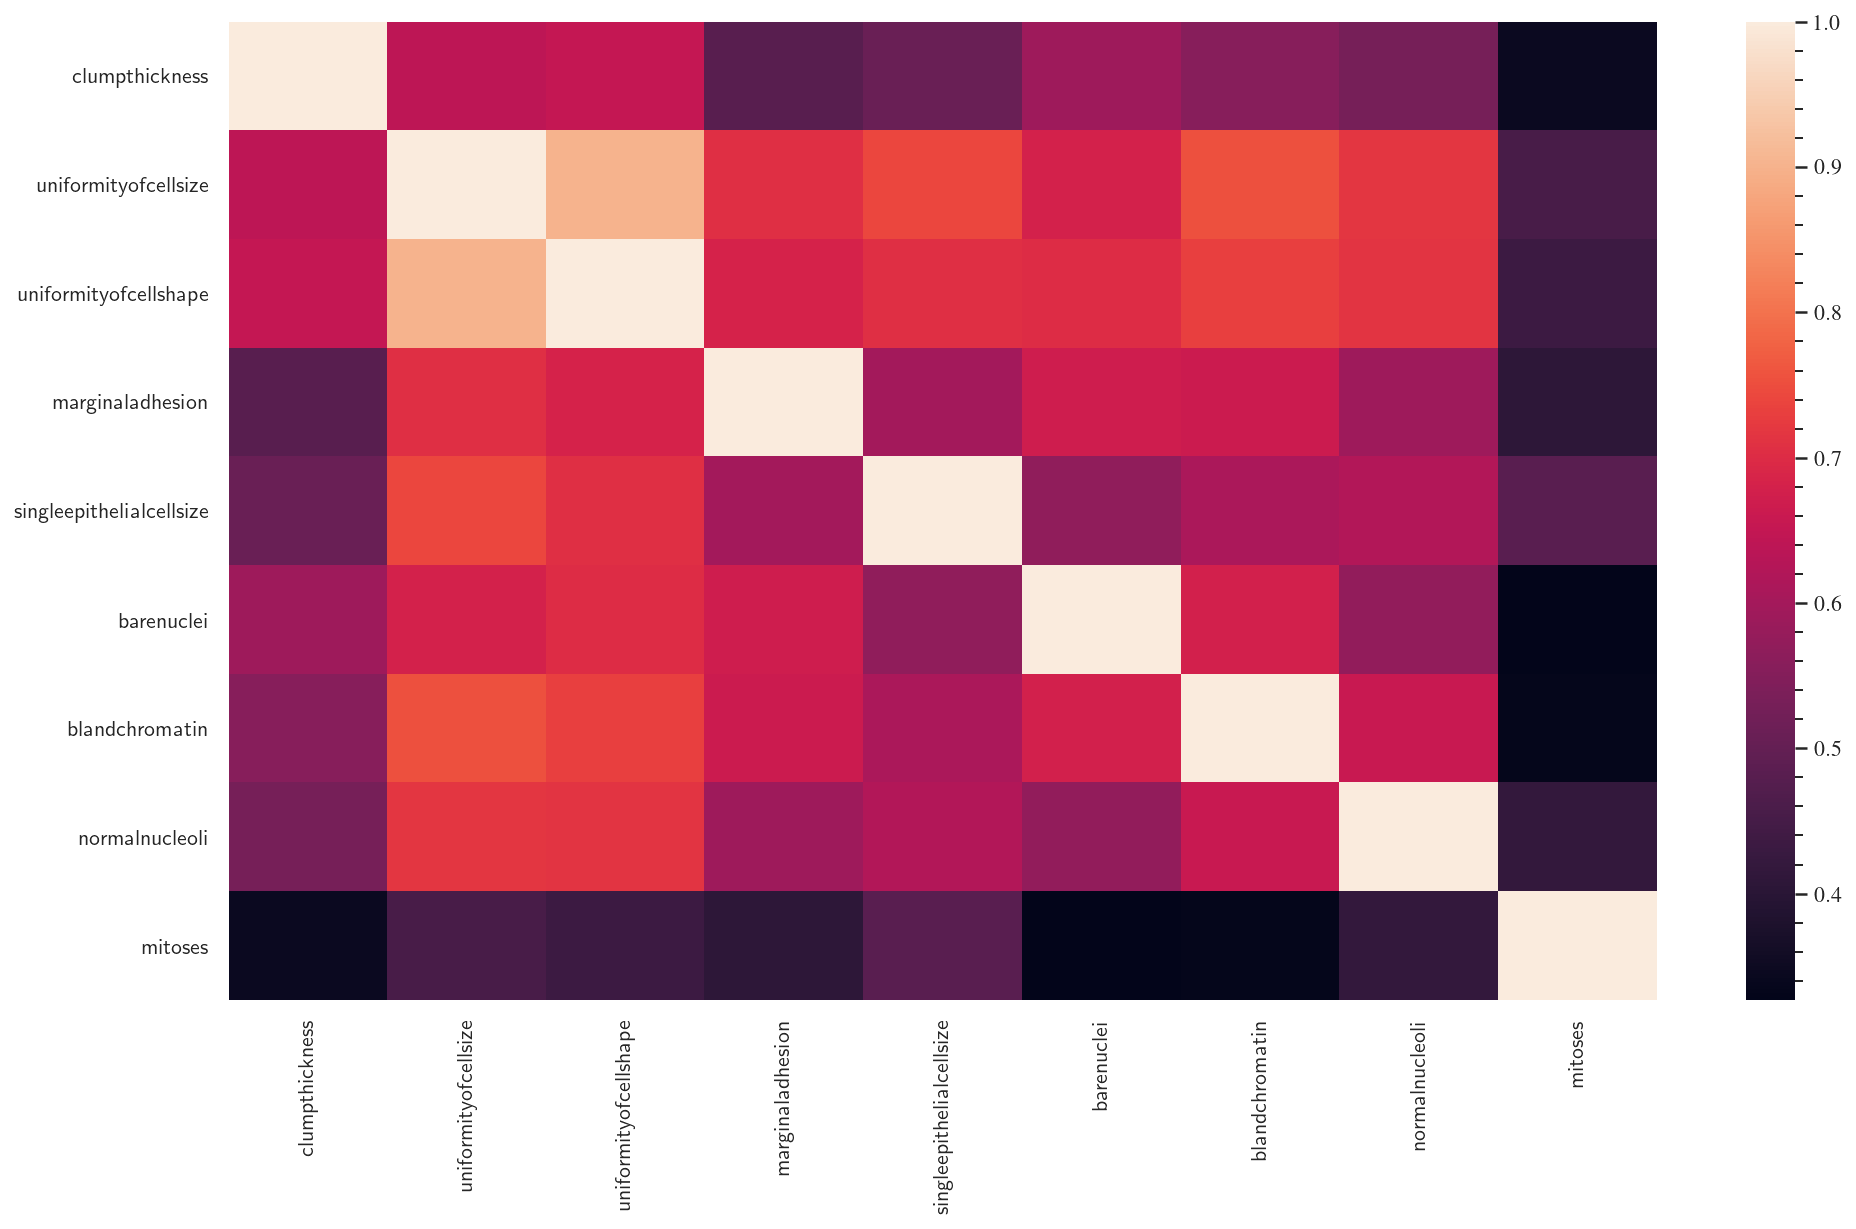

In [31]:
corr = df.loc[:, df.columns != 'id'].corr()
sns.heatmap(corr)
corr.style.background_gradient(cmap='coolwarm')

Note two very correlated features

In [32]:
df.head()

,id,clumpthickness,uniformityofcellsize,uniformityofcellshape,marginaladhesion,singleepithelialcellsize,barenuclei,blandchromatin,normalnucleoli,mitoses,class
0,1241035,7,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,4
1,1107684,6,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,4
2,691628,8,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,4
3,1226612,7,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,4
4,1142706,5,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,4


replace class 2 -> malignant, so we will replace 2 w/ 1

replace class 4 -> benign, so we will replace 4 w/ 0


In [33]:
map_dict = {4.: 0, 2.: 1}
df["class"] = df["class"].map(map_dict) 
df.rename(columns={'class': 'malignant'}, inplace=True)

In [34]:
df.head()

,id,clumpthickness,uniformityofcellsize,uniformityofcellshape,marginaladhesion,singleepithelialcellsize,barenuclei,blandchromatin,normalnucleoli,mitoses,malignant
0,1241035,7,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,0
1,1107684,6,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,0
2,691628,8,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,0
3,1226612,7,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,0
4,1142706,5,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,0


## missing data

In [35]:
print("Calculate the % of missing values in each row")
df.isna().mean() 

Calculate the % of missing values in each row


id                          0.000000
clumpthickness              0.000000
uniformityofcellsize        0.000000
uniformityofcellshape       0.000000
marginaladhesion            0.000000
singleepithelialcellsize    0.000000
barenuclei                  0.024883
blandchromatin              0.000000
normalnucleoli              0.000000
mitoses                     0.000000
malignant                   0.000000
dtype: float64

In [36]:
np.isnan(df.barenuclei).sum()

16

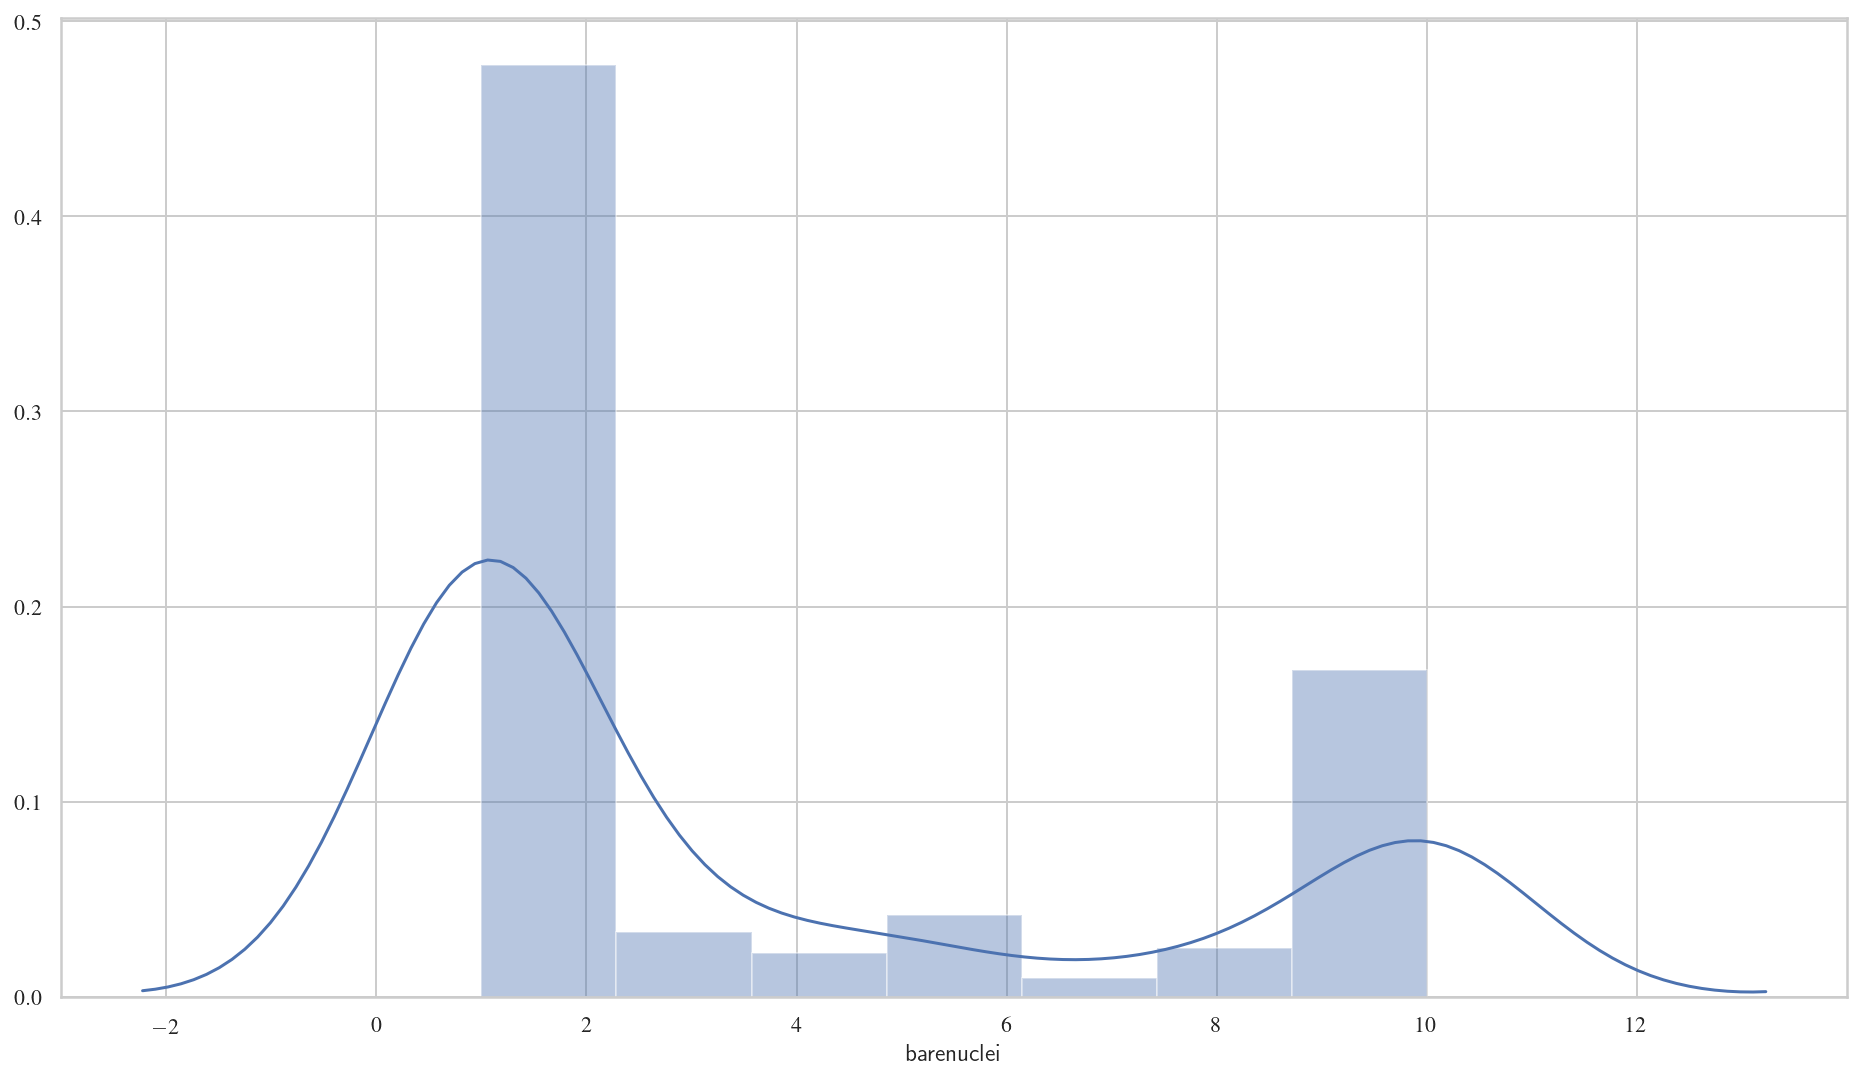

In [37]:
sns.distplot(df.barenuclei)
plt.show()

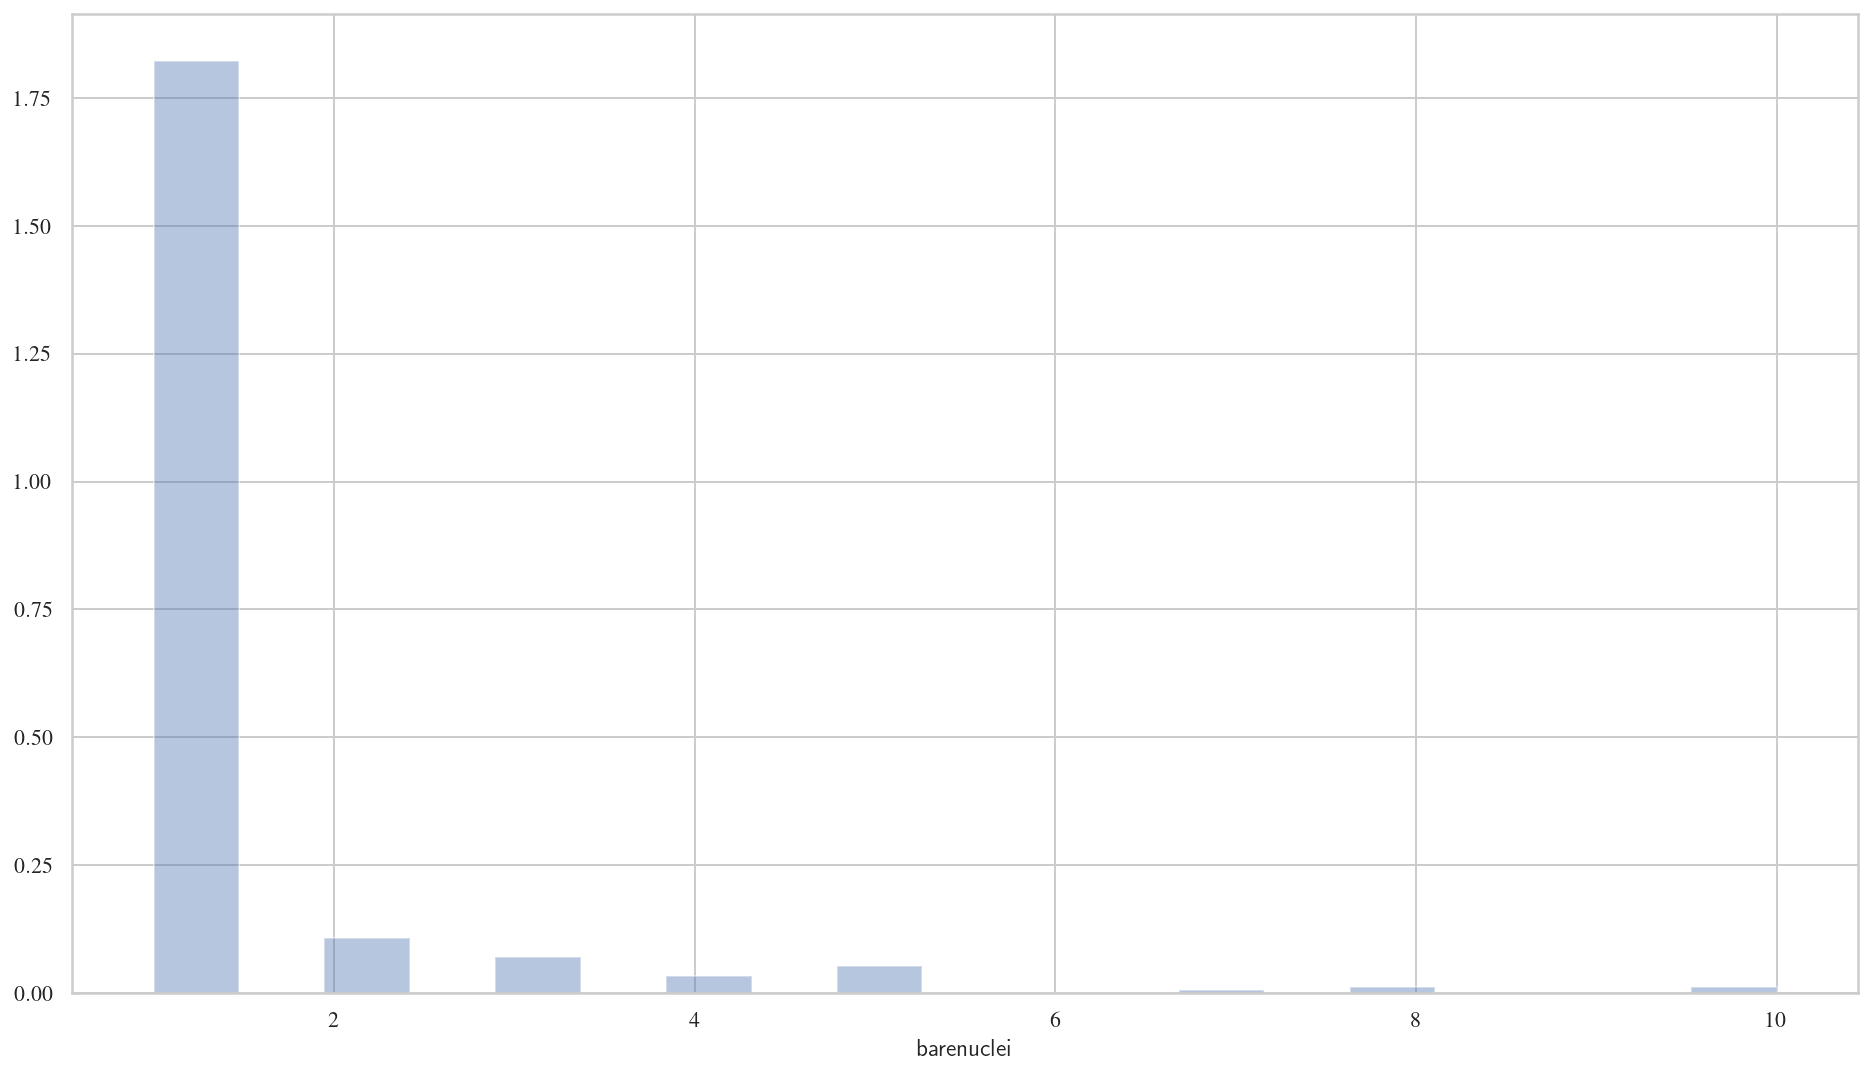

In [38]:
sns.distplot(df.barenuclei.loc[df.malignant==1])
plt.show()

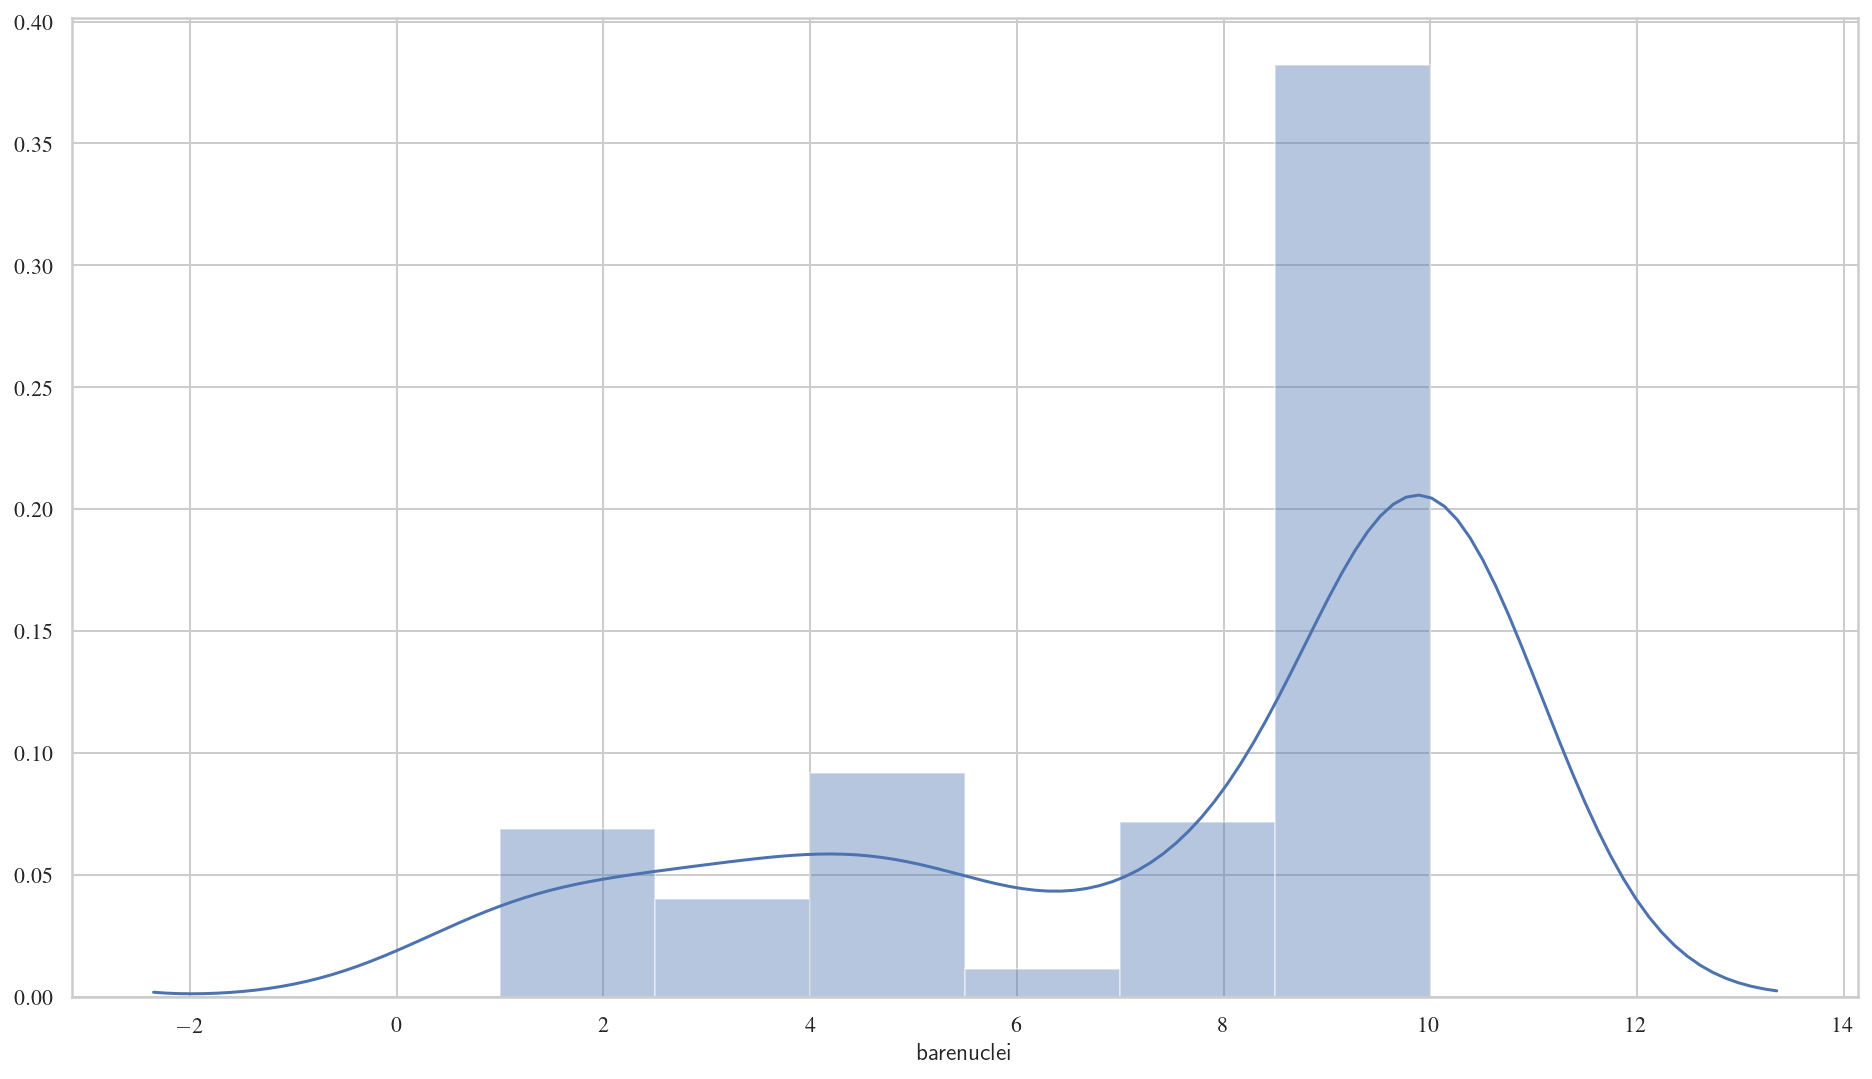

In [39]:
sns.distplot(df.barenuclei.loc[df.malignant==0])
plt.show()

In [41]:
tmp = df.select_dtypes(exclude=['object'])
tmp = tmp.loc[:, tmp.columns != 'id']
tmp.columns

Index(['clumpthickness', 'uniformityofcellsize', 'uniformityofcellshape',
       'marginaladhesion', 'singleepithelialcellsize', 'barenuclei',
       'blandchromatin', 'normalnucleoli', 'mitoses', 'malignant'],
      dtype='object')

<Figure size 800x640 with 0 Axes>

<Figure size 800x640 with 0 Axes>

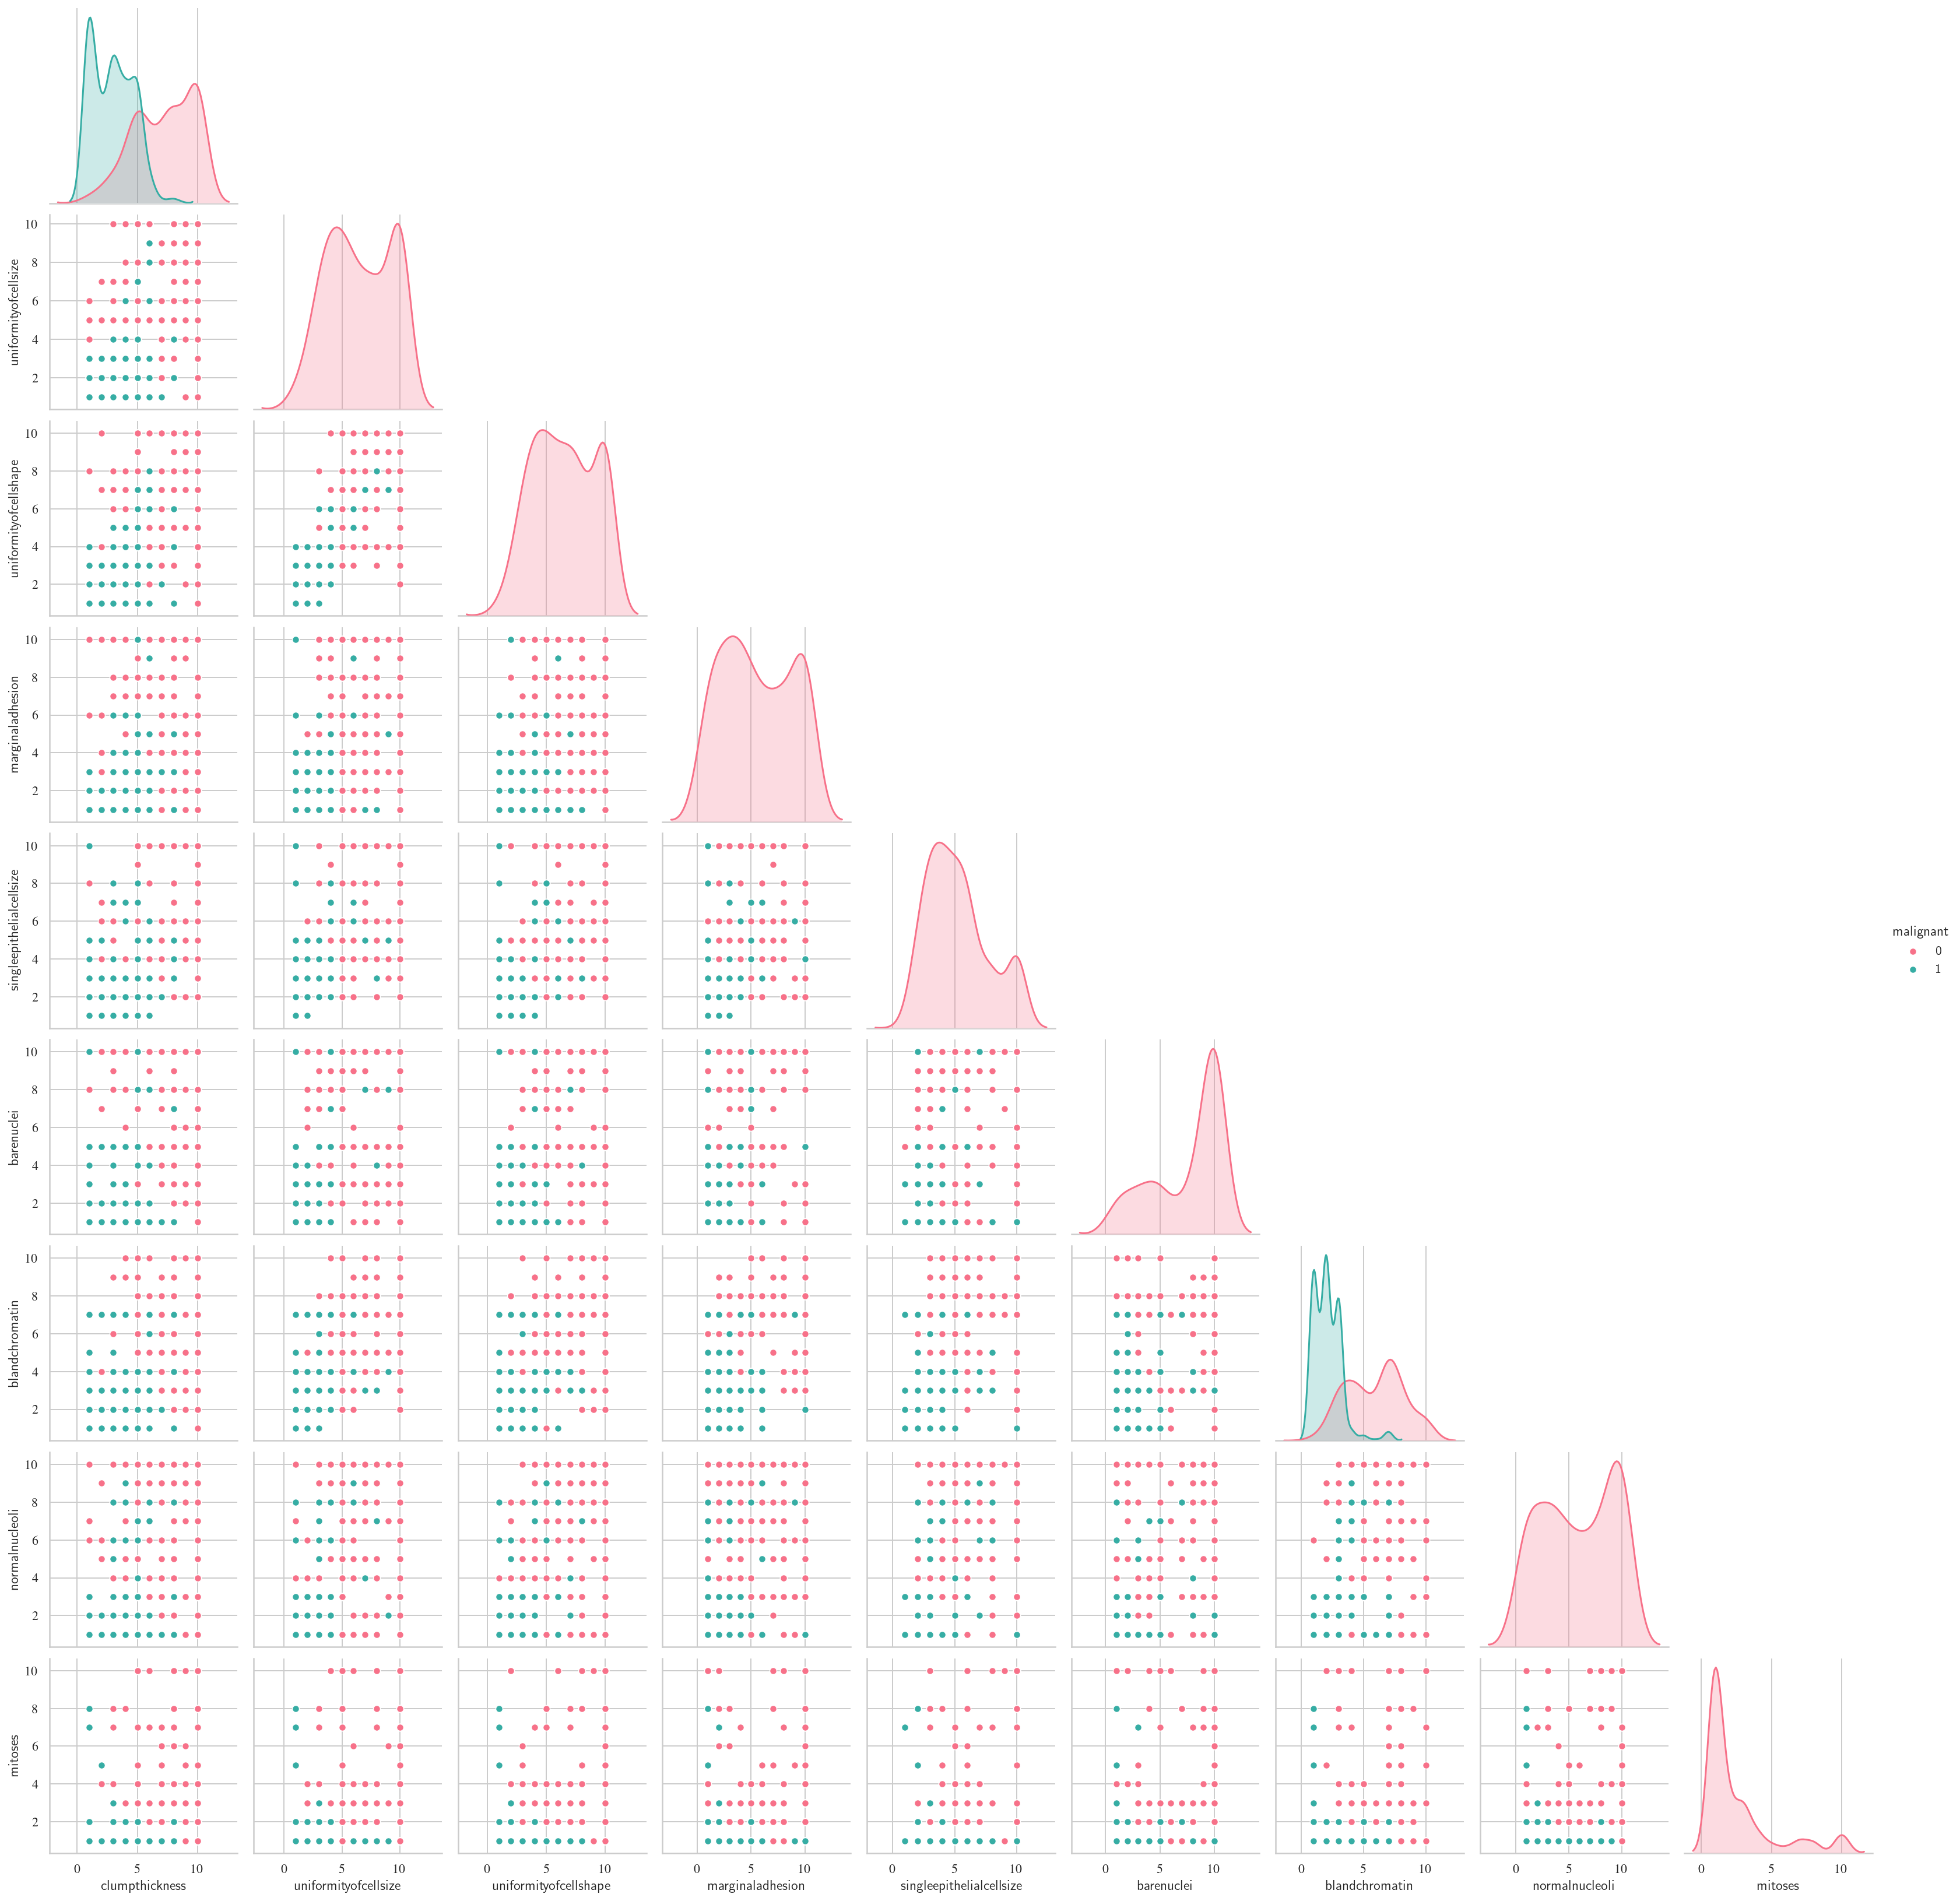

In [49]:
plt.figure(figsize=(10, 8), dpi=80)
sns.pairplot(tmp, 
             hue="malignant", palette="husl", corner=True)
plt.show()


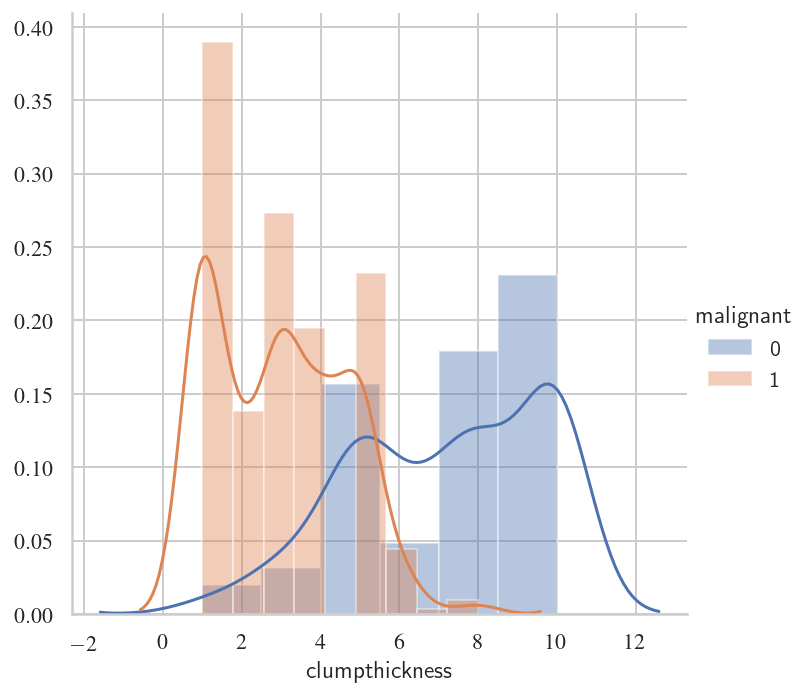

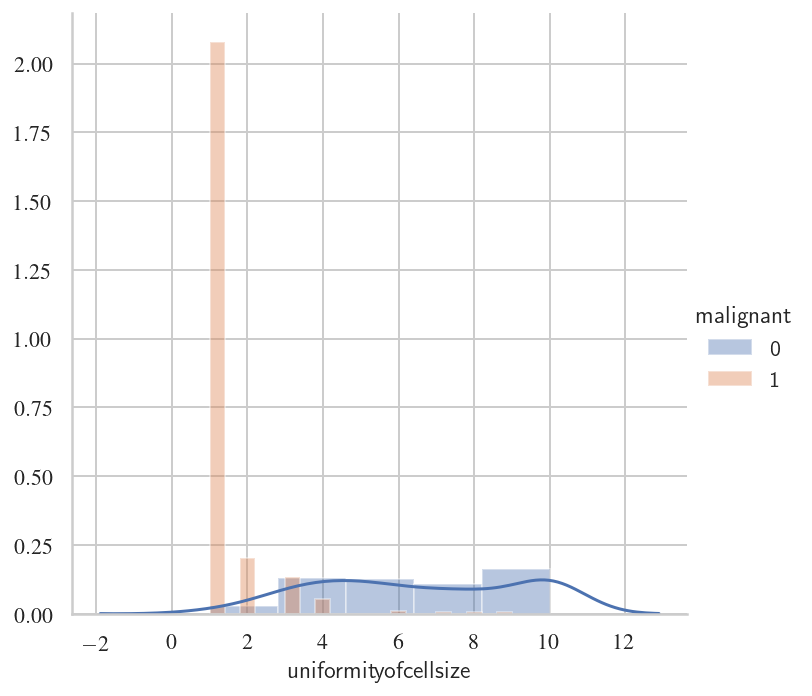

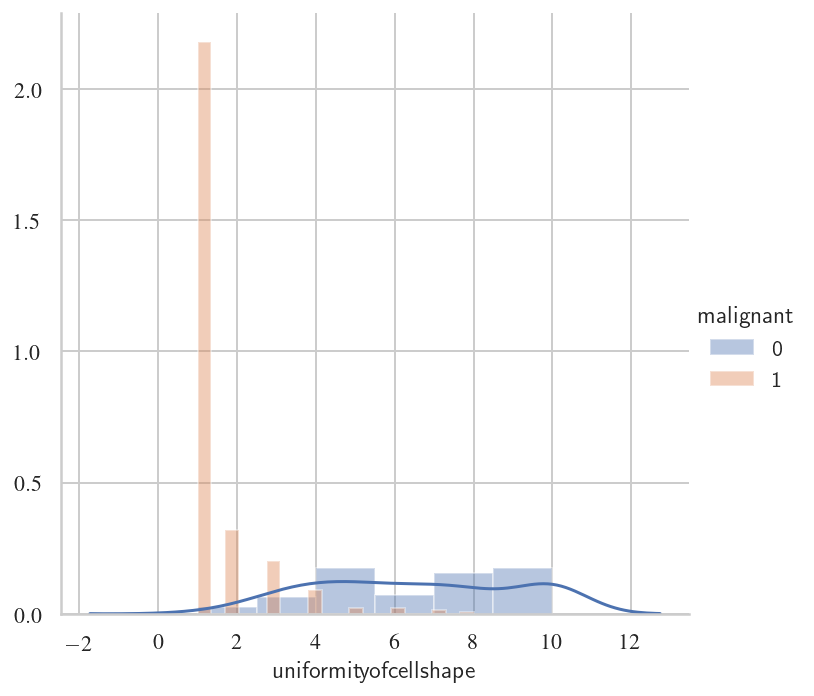

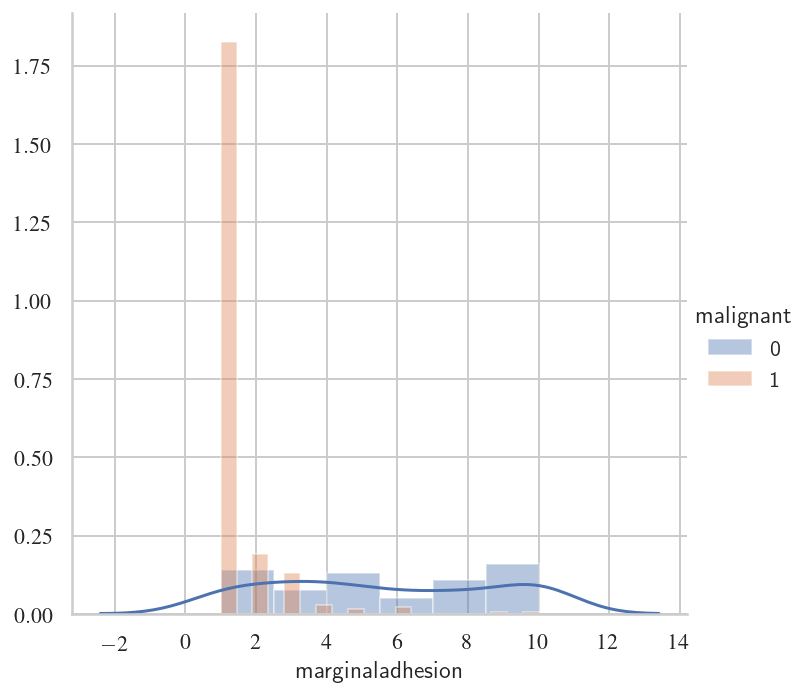

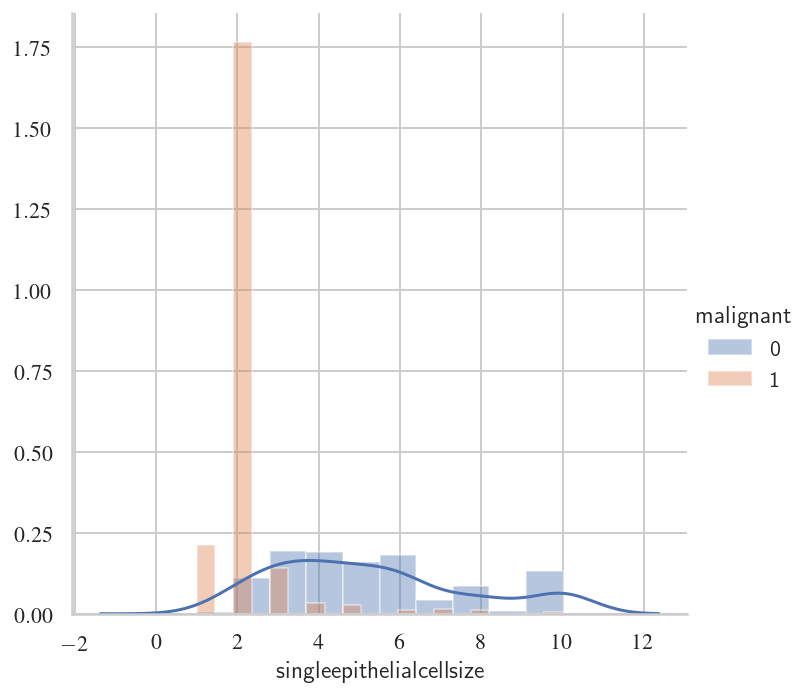

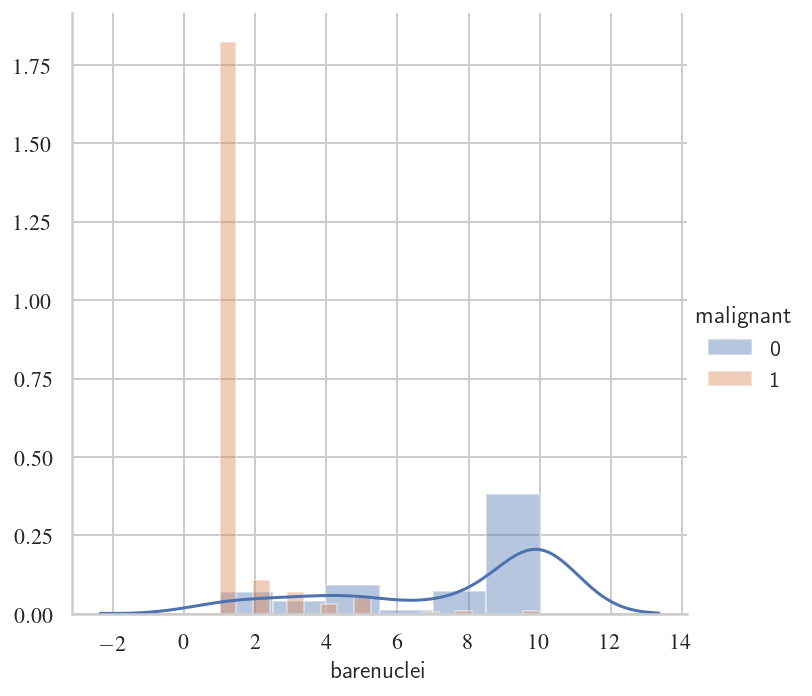

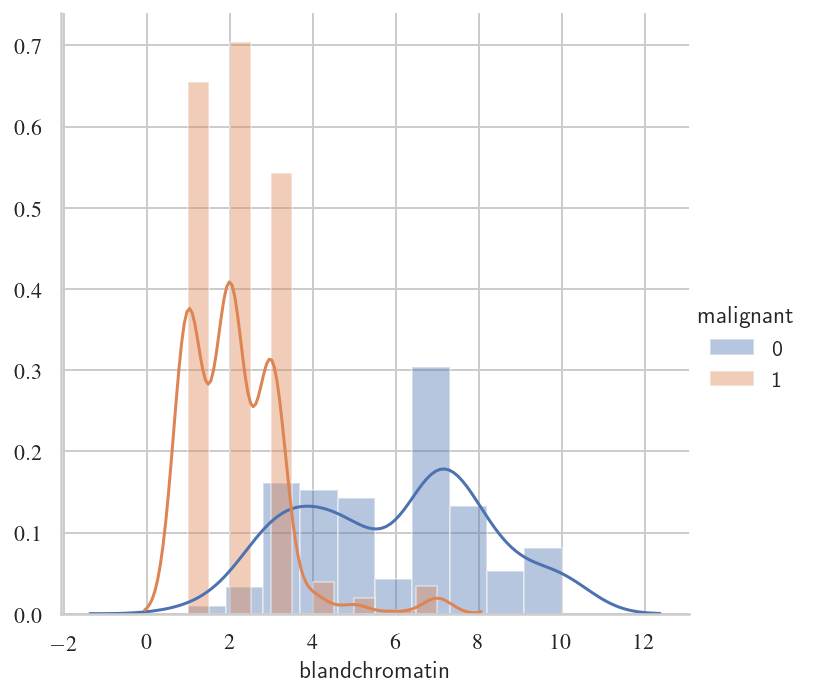

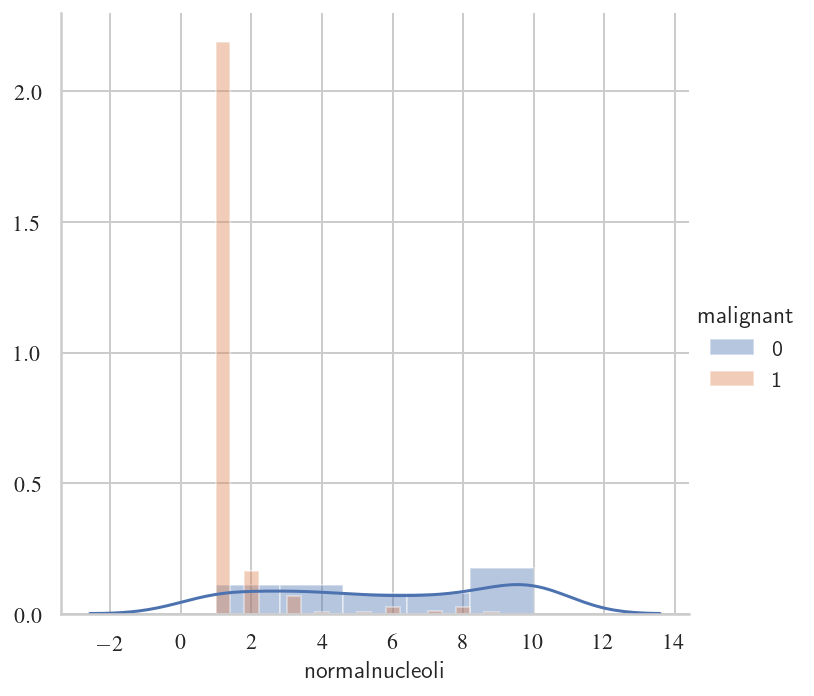

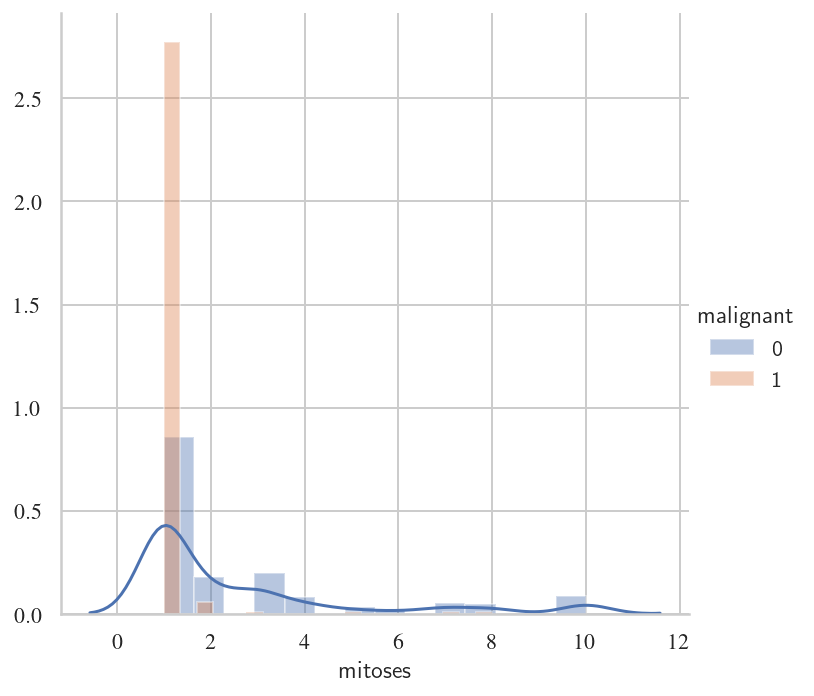

In [55]:
# plotting distribution plot for all features

for idx, feature in enumerate(list(tmp.columns)[:-1]):
    fg = sns.FacetGrid(tmp, hue='malignant', size=5)
    fg.map(sns.distplot, feature).add_legend()
    plt.show()

In [ ]:
g = sns.PairGrid(tmp, hue="malignant", hue_kws={"cmap": ["Greens", "Reds"]})
g = g.map_diag(sns.kdeplot, lw=3)
g = g.map_offdiag(sns.kdeplot, lw=1)
plt.show()

Text(0.5, 1.0, 'Class distribution Histogram')

Text(0.5, 0, 'Malignant or not')

Text(0, 0.5, 'Frequency')

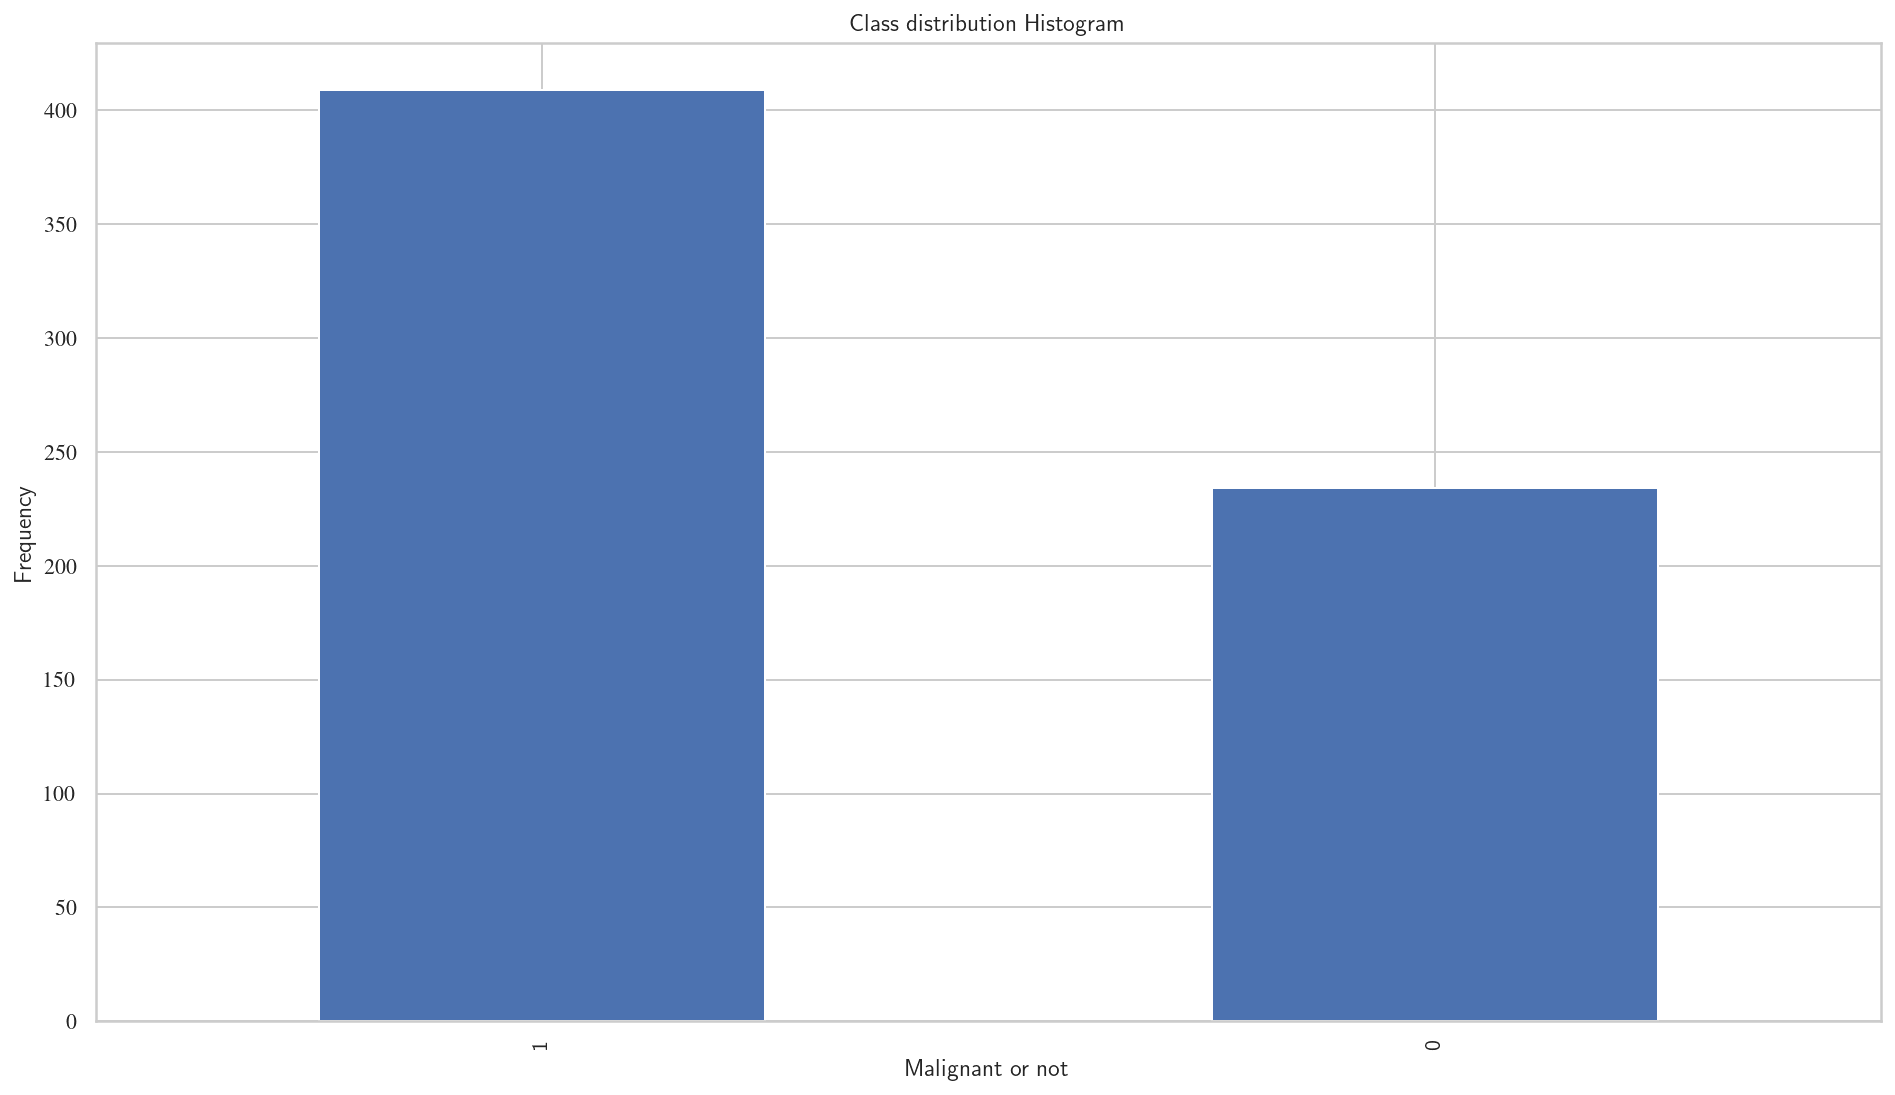

In [51]:
count_classes = pd.value_counts(df["malignant"])
count_classes.plot(kind = 'bar')
plt.title("Class distribution Histogram")
plt.xlabel("Malignant or not")
plt.ylabel("Frequency")
plt.show()


## Impute using mode of each class

In [236]:
from scipy.stats import mode

In [ ]:
# add a column to indicate whether it was missing data
# df['barenuclei_imputed'] = np.isnan(df.barenucleis)

In [270]:
df.barenuclei[(np.isnan(df.barenuclei)) & (df.malignant==1)] = df.barenuclei.loc[df.malignant==1].mode()[0]
df.barenuclei[(np.isnan(df.barenuclei)) & (df.malignant ==0)] = df.barenuclei.loc[df.malignant==0].mode()[0]

In [272]:
print("Calculate the % of missing values in each row")
df.isna().mean() 

Calculate the % of missing values in each row


id                          0.0
clumpthickness              0.0
uniformityofcellsize        0.0
uniformityofcellshape       0.0
marginaladhesion            0.0
singleepithelialcellsize    0.0
barenuclei                  0.0
blandchromatin              0.0
normalnucleoli              0.0
mitoses                     0.0
malignant                   0.0
dtype: float64

## save cleaned data

In [273]:
df.to_csv('../data/cleaned/cancer.csv', index=False)

## any imbalance in class?

In [274]:
# Count the number of malignant vs. belign
m = (df['malignant'] == 1).sum()
b = (df['malignant'] == 0.).sum()
target = pd.Series([m, b], name='target', index=['malignant', 'benign'])
target

malignant    409
benign       234
Name: target, dtype: int64

Text(0.5, 1.0, 'Class distribution Histogram')

Text(0.5, 0, 'Malignant or not')

Text(0, 0.5, 'Frequency')

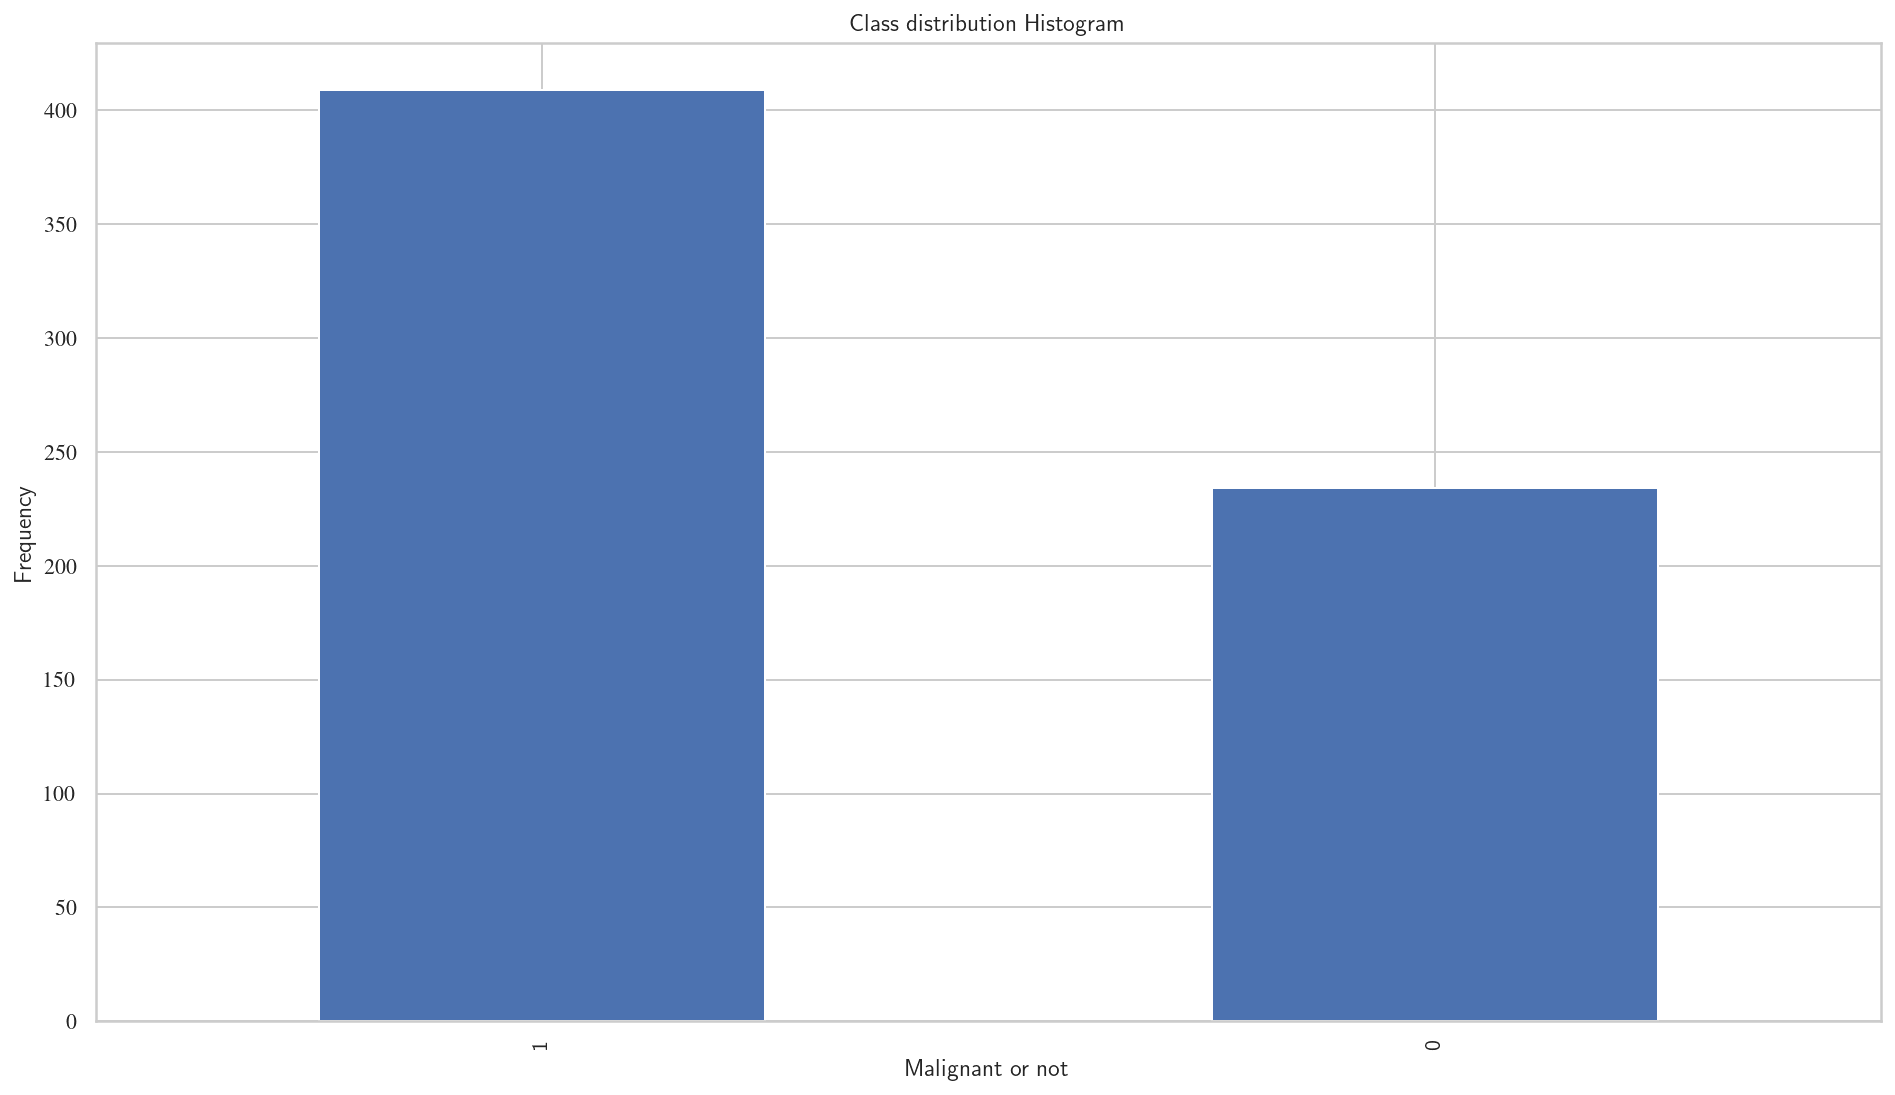

In [50]:
count_classes = pd.value_counts(df["malignant"])
count_classes.plot(kind = 'bar')
plt.title("Class distribution Histogram")
plt.xlabel("Malignant or not")
plt.ylabel("Frequency")
plt.show()


## Split into features X and label Y

In [275]:
X = df.loc[:, df.columns != 'malignant']
X = X.loc[:, X.columns != 'id']
Y = df['malignant']

In [276]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 0 to 15779
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clumpthickness            643 non-null    int64  
 1   uniformityofcellsize      643 non-null    float64
 2   uniformityofcellshape     643 non-null    float64
 3   marginaladhesion          643 non-null    float64
 4   singleepithelialcellsize  643 non-null    float64
 5   barenuclei                643 non-null    float64
 6   blandchromatin            643 non-null    float64
 7   normalnucleoli            643 non-null    float64
 8   mitoses                   643 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 70.2 KB


In [476]:
idex = y_test ==1
idex.to_list()
X_test[idex.to_list()].iloc[0]

clumpthickness              2.0
uniformityofcellsize        1.0
uniformityofcellshape       1.0
marginaladhesion            1.0
singleepithelialcellsize    2.0
barenuclei                  1.0
blandchromatin              2.0
normalnucleoli              1.0
mitoses                     1.0
Name: 6937, dtype: float64

# Analysis/Modeling - Classification, feature importance
1. What features of a cell are the largest drivers of malignancy? Build a model that predicts whether a given biopsied breast cell is benign or malignant.
2. What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 

**Models**
- logistic + L1 regularization (feature selection)
- RF feature importance (but we only have a small sample size, so the number of parameters in RF may not be best)
 

## LR 


In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.3)

In [278]:
# normalize because we will regularize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [482]:
X_test.shape

(193, 9)

In [279]:
import sys
sys.path.append('../src')

In [280]:
np.isnan(X_train_scaled).sum()

0

In [316]:
len(Y[Y == 0])
len(Y[Y == 1])

234

409

In [317]:
## weighted logistic regression
w = {0: 409/234., 1:1}

In [303]:
# find best threshold for maximizing F1 for binary predictions
def bestThresshold(y_true, y_pred):
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_true, np.array(y_pred)>thresh)    # y_pred > thresh to yield output [0,1] based on new threshold, y_pred is list of probabilities
        if score > best_score:
            best_thresh = thresh
            best_score = score
    return best_score , best_thresh

In [318]:
# optimize C w/ l1
def cv_run(X_train, X_test, y_train, y_test, C=[0.001, 0.1, 1, 10, 100], scoring='f1',  # 'roc_auc'
           cv=5):

    for c in C:
        clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', class_weight=w).fit(X_train_scaled, y_train)
        y_train_pred = clf.predict(X_train_scaled)
        f1score = f1_score(y_train, y_train_pred)
    
        print('F1 of Logistic regression classifier on training set: {:.2f}'
             .format(f1_score(y_train, clf.predict(X_train_scaled))))
        
        cvmethod = KFold(n_splits=cv, shuffle=True)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cvmethod, scoring=scoring)

        print('Cross-validation scores (3-fold):', cv_scores)
        print('Mean cross-validation score (3-fold): {:.3f}'
                                                         .format(np.mean(cv_scores)))
        

# skip plotting validation curve
    

In [319]:
cv_run(X_train, X_test, y_train, y_test)

F1 of Logistic regression classifier on training set: 0.00
Cross-validation scores (3-fold): [0. 0. 0. 0. 0.]
Mean cross-validation score (3-fold): 0.000
F1 of Logistic regression classifier on training set: 0.97
Cross-validation scores (3-fold): [0.99173554 0.96666667 0.92982456 0.99082569 0.96825397]
Mean cross-validation score (3-fold): 0.969
F1 of Logistic regression classifier on training set: 0.98
Cross-validation scores (3-fold): [0.96610169 0.97637795 1.         0.98360656 0.91743119]
Mean cross-validation score (3-fold): 0.969
F1 of Logistic regression classifier on training set: 0.98
Cross-validation scores (3-fold): [0.976      0.99047619 0.96428571 0.95384615 0.97435897]
Mean cross-validation score (3-fold): 0.972
F1 of Logistic regression classifier on training set: 0.98
Cross-validation scores (3-fold): [0.98113208 0.98214286 0.97560976 0.96774194 0.95934959]
Mean cross-validation score (3-fold): 0.973


## Final model for LR

In [355]:
c = 100
clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', class_weight=w).fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
f1score = f1_score(y_train, y_train_pred)

y_predict = clf.predict(X_test_scaled)

print('Coefficient of each feature:', clf.coef_)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
print('F1 of Logistic regression classifier on training set: {:.2f}'
     .format(f1_score(y_train, clf.predict(X_train_scaled))))
print('F1 of Logistic regression classifier on test set: {:.2f}'
     .format(f1_score(y_test, y_predict)))
print('Recall of Logistic regression classifier on training set: {:.2f}'
     .format(recall_score(y_train, clf.predict(X_train_scaled))))
print('Recall of Logistic regression classifier on test set: {:.2f}'
     .format(recall_score(y_test, y_predict)))
print('\n')

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_predict)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_predict)}')

Coefficient of each feature: [[-5.90554454  0.71340141 -2.61455083 -3.62059896 -0.31767816 -4.92175739
  -1.87467865 -2.36263317 -6.11158704]]
Accuracy of Logistic regression classifier on training set: 0.97
Accuracy of Logistic regression classifier on test set: 0.97
F1 of Logistic regression classifier on training set: 0.98
F1 of Logistic regression classifier on test set: 0.97
Recall of Logistic regression classifier on training set: 0.98
Recall of Logistic regression classifier on test set: 0.96


Confusion Matrix: 
[[ 77   1]
 [  5 110]]
Area Under Curve: 0.971850613154961


Want to max. recall or TP and min FN

In [336]:
#Combining coeff and variable names
coef_dict = {}
for coef, feat in zip(clf.coef_[0,:],X.columns):
    coef_dict[feat] = coef
coef_dict    

{'clumpthickness': -5.908063753722311,
 'uniformityofcellsize': 0.711150007343503,
 'uniformityofcellshape': -2.6107542848327703,
 'marginaladhesion': -3.6198029399807345,
 'singleepithelialcellsize': -0.31790783259742234,
 'barenuclei': -4.9225097924451235,
 'blandchromatin': -1.8737103090520182,
 'normalnucleoli': -2.3630388000292997,
 'mitoses': -6.11232717947919}

In [485]:
# save model
import pickle
from sklearn.externals import joblib
pickle.dump(clf, open('../model/LR_l1_tuned.mod', 'wb'))
joblib.dump(scaler, '../model/LR_l1_tuned.scaler')

['../model/LR_l1_tuned.scaler']

## ROC curve
ROC tells us how good the model is for distinguishing the given classes, in terms of the predicted probability.
ROC uses different thresholds to plot the relationship between TPR-FPR


In [337]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [348]:
# probab on test data
lr_probs = clf.predict_proba(X_test_scaled)[:, 1]     # for positive class
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)

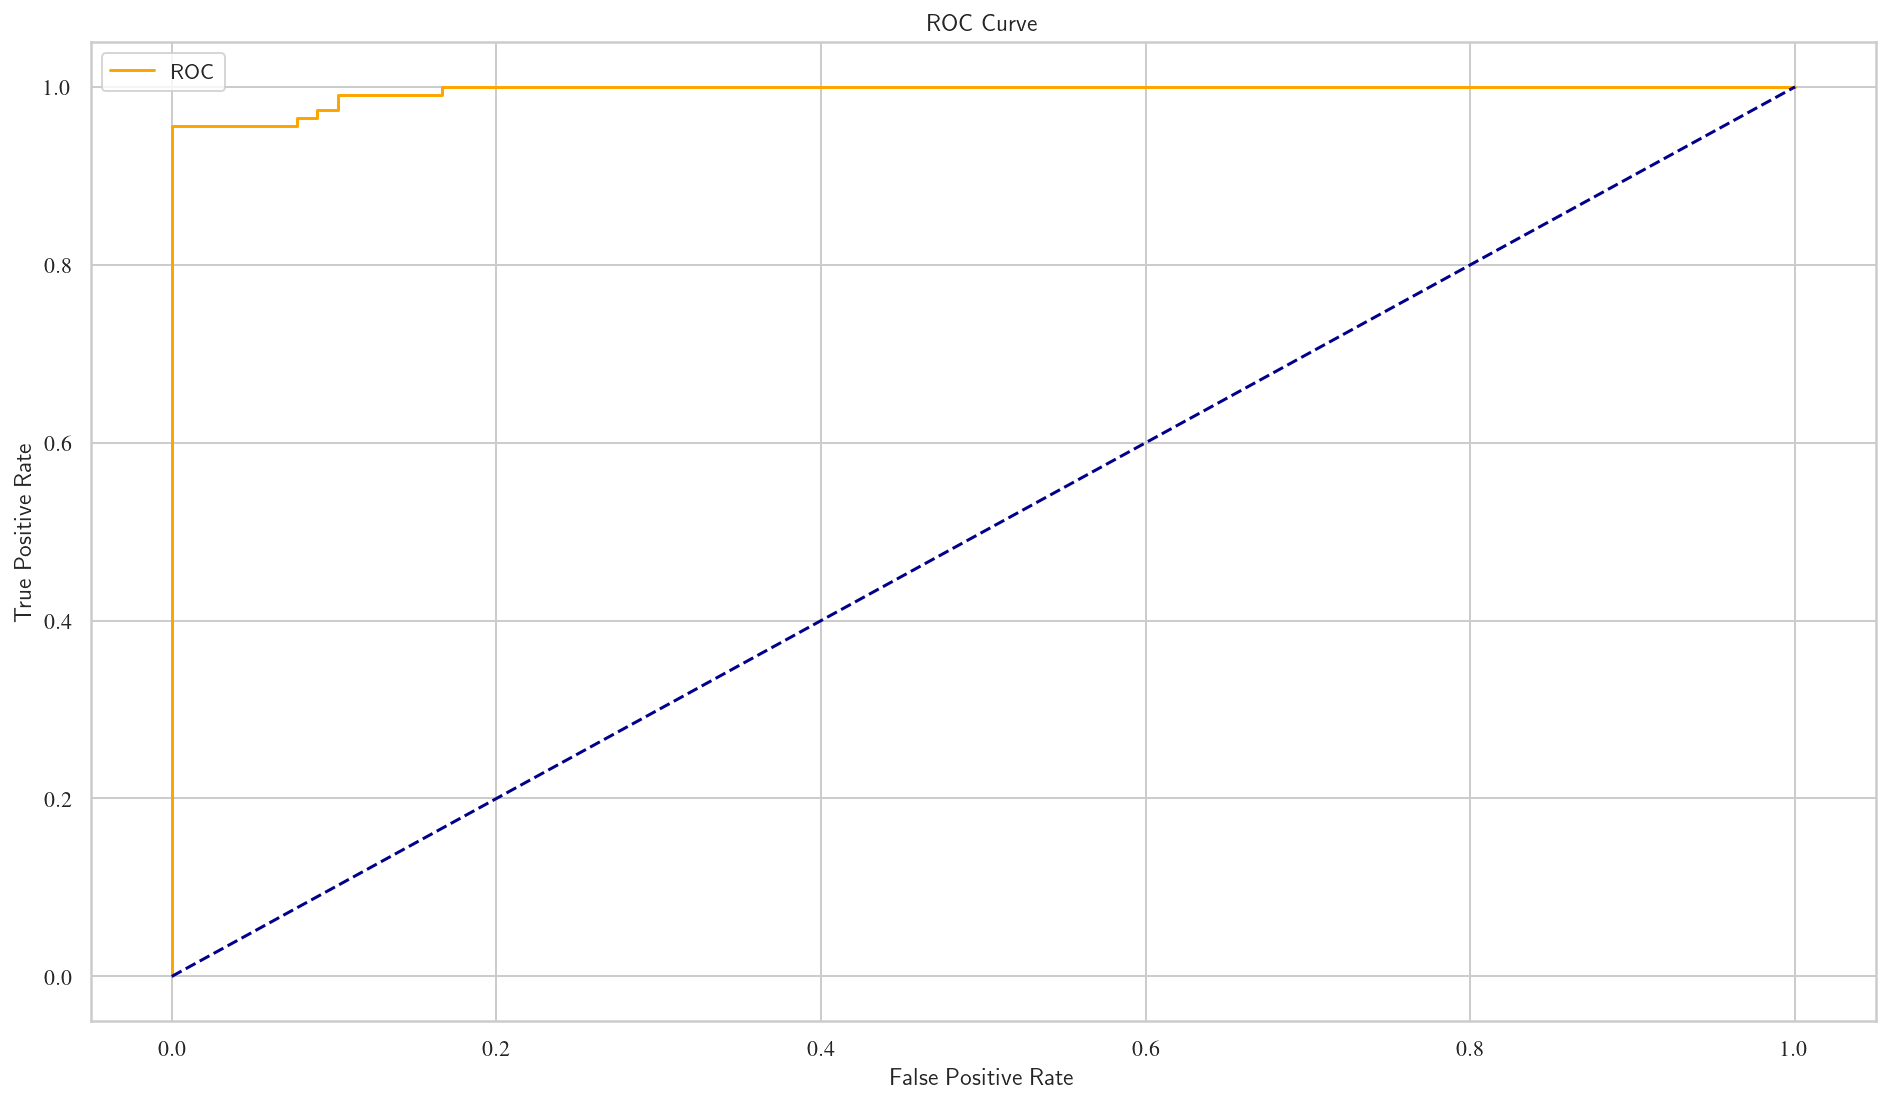

In [349]:
plot_roc_curve(fpr, tpr)

## PR curve

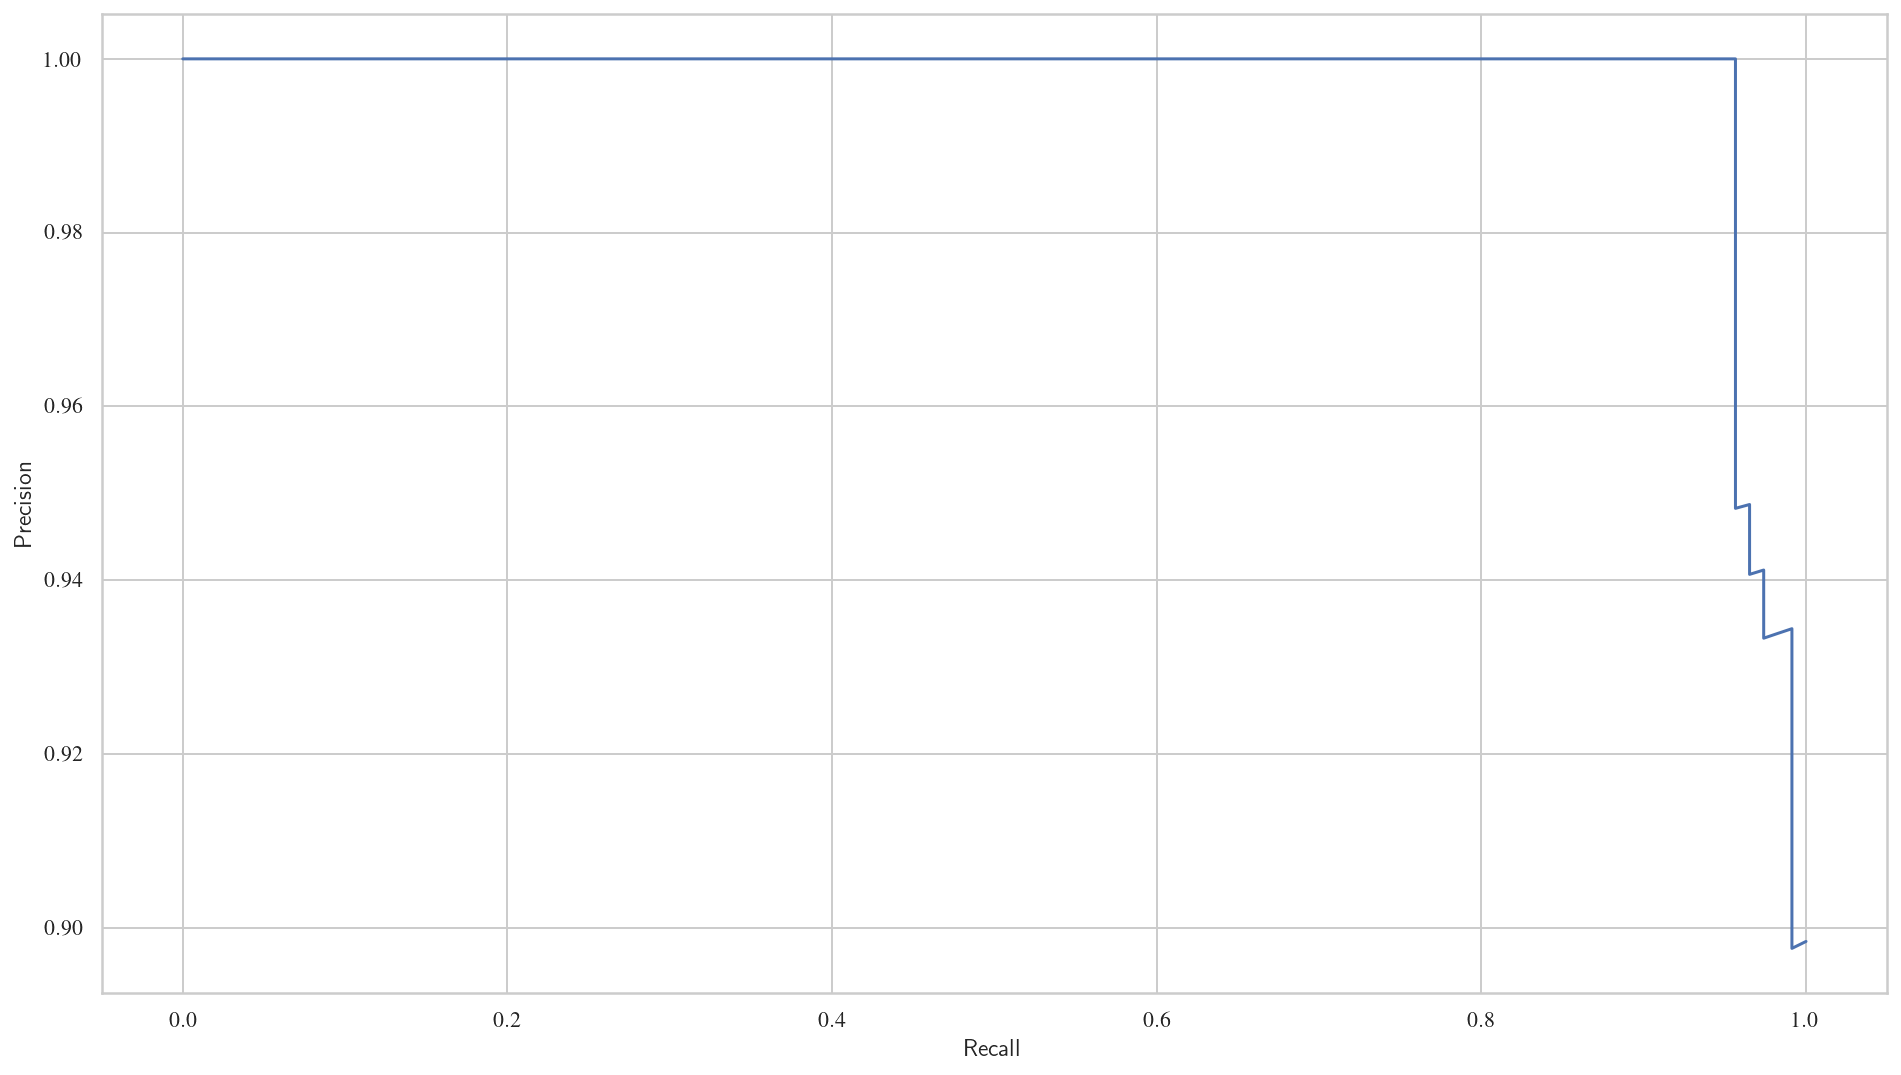

In [366]:
y_scores_lr = clf.decision_function(X_test_scaled)
# print(y_scores_lr)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_lr)    
# recall = recalls[np.argmin(np.abs(precisions - 0.75))]
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show();

## feature selection
 1. coefficient values, 
 2. recursive feature elimination (RFE) 
 3. sci-kit Learn’s SelectFromModels (SFM).

In [381]:
sorted(coef_dict.items(), key=lambda x: x[1])

[('mitoses', -6.11232717947919),
 ('clumpthickness', -5.908063753722311),
 ('barenuclei', -4.9225097924451235),
 ('marginaladhesion', -3.6198029399807345),
 ('uniformityofcellshape', -2.6107542848327703),
 ('normalnucleoli', -2.3630388000292997),
 ('blandchromatin', -1.8737103090520182),
 ('singleepithelialcellsize', -0.31790783259742234),
 ('uniformityofcellsize', 0.711150007343503)]

In [378]:
selector = RFE(clf, n_features_to_select=1).fit(X_train_scaled, y_train);
order = selector.ranking_
order

array([3, 8, 1, 5, 9, 2, 7, 6, 4])

In [380]:
feature_ranks = []
for i in order-1:
    feature_ranks.append(f"{i+1}.{X_train.columns[i]}")
feature_ranks                         

['3.uniformityofcellshape',
 '8.normalnucleoli',
 '1.clumpthickness',
 '5.singleepithelialcellsize',
 '9.mitoses',
 '2.uniformityofcellsize',
 '7.blandchromatin',
 '6.barenuclei',
 '4.marginaladhesion']

In [384]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold=-np.inf)
smf.fit(X_train_scaled, y_train)
feature_idx = smf.get_support()        # True for feautres that lasso thinks important
feature_name = X_train.columns[feature_idx]
feature_name

SelectFromModel(estimator=LogisticRegression(C=100,
                                             class_weight={0: 1.7478632478632479,
                                                           1: 1},
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=-inf)

Index(['clumpthickness', 'uniformityofcellsize', 'uniformityofcellshape',
       'marginaladhesion', 'singleepithelialcellsize', 'barenuclei',
       'blandchromatin', 'normalnucleoli', 'mitoses'],
      dtype='object')

## Visualize: PCA + DB

In [416]:
def plot_boundary(X, y, fitted_model):

    plt.figure(figsize=(8,5), dpi=100)
    
    for i, plot_type in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1,2,i+1)

        mesh_step_size = 0.01  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
        if i == 0:
            Z = fitted_model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                Z = fitted_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                     verticalalignment='center', transform = plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        Z = Z.reshape(xx.shape)
        plt.scatter(X[y.values==0,0], X[y.values==0,1], alpha=0.4, label='Edible', s=5)
        plt.scatter(X[y.values==1,0], X[y.values==1,1], alpha=0.4, label='Posionous', s=5)
        plt.imshow(Z, interpolation='nearest', cmap='RdYlBu_r', alpha=0.15, 
                   extent=(x_min, x_max, y_min, y_max), origin='lower')
        plt.title(plot_type + '\n' + 
                  str(fitted_model).split('(')[0]+ ' Test Accuracy: ' + str(np.round(fitted_model.score(X, y), 5)))
        plt.gca().set_aspect('equal');
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.02)

In [392]:
from sklearn.decomposition import PCA

In [415]:
# reduce to 2 dimm
pca = PCA(n_components=2)
pca.fit_transform(X)
pca.explained_variance_ratio_
print(abs( pca.components_ ))

array([[ 7.5823621 ,  2.03936221],
       [10.70824389, -0.03740666],
       [ 5.82524292,  4.15702567],
       ...,
       [13.51995737,  0.37064859],
       [ 4.89732106,  3.22641998],
       [ 5.24230778, -5.24045746]])

array([0.68379912, 0.0755679 ])

[[0.29912265 0.40360781 0.390619   0.33429646 0.24697972 0.44042606
  0.2911742  0.35843991 0.12269216]
 [0.12223367 0.22182881 0.15824168 0.06353875 0.2094691  0.77373457
  0.00280741 0.48197062 0.17868202]]


<Figure size 1920x1080 with 0 Axes>

Text(0.5, 1.0, 'cancer Set\nFirst Two Principal Components')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

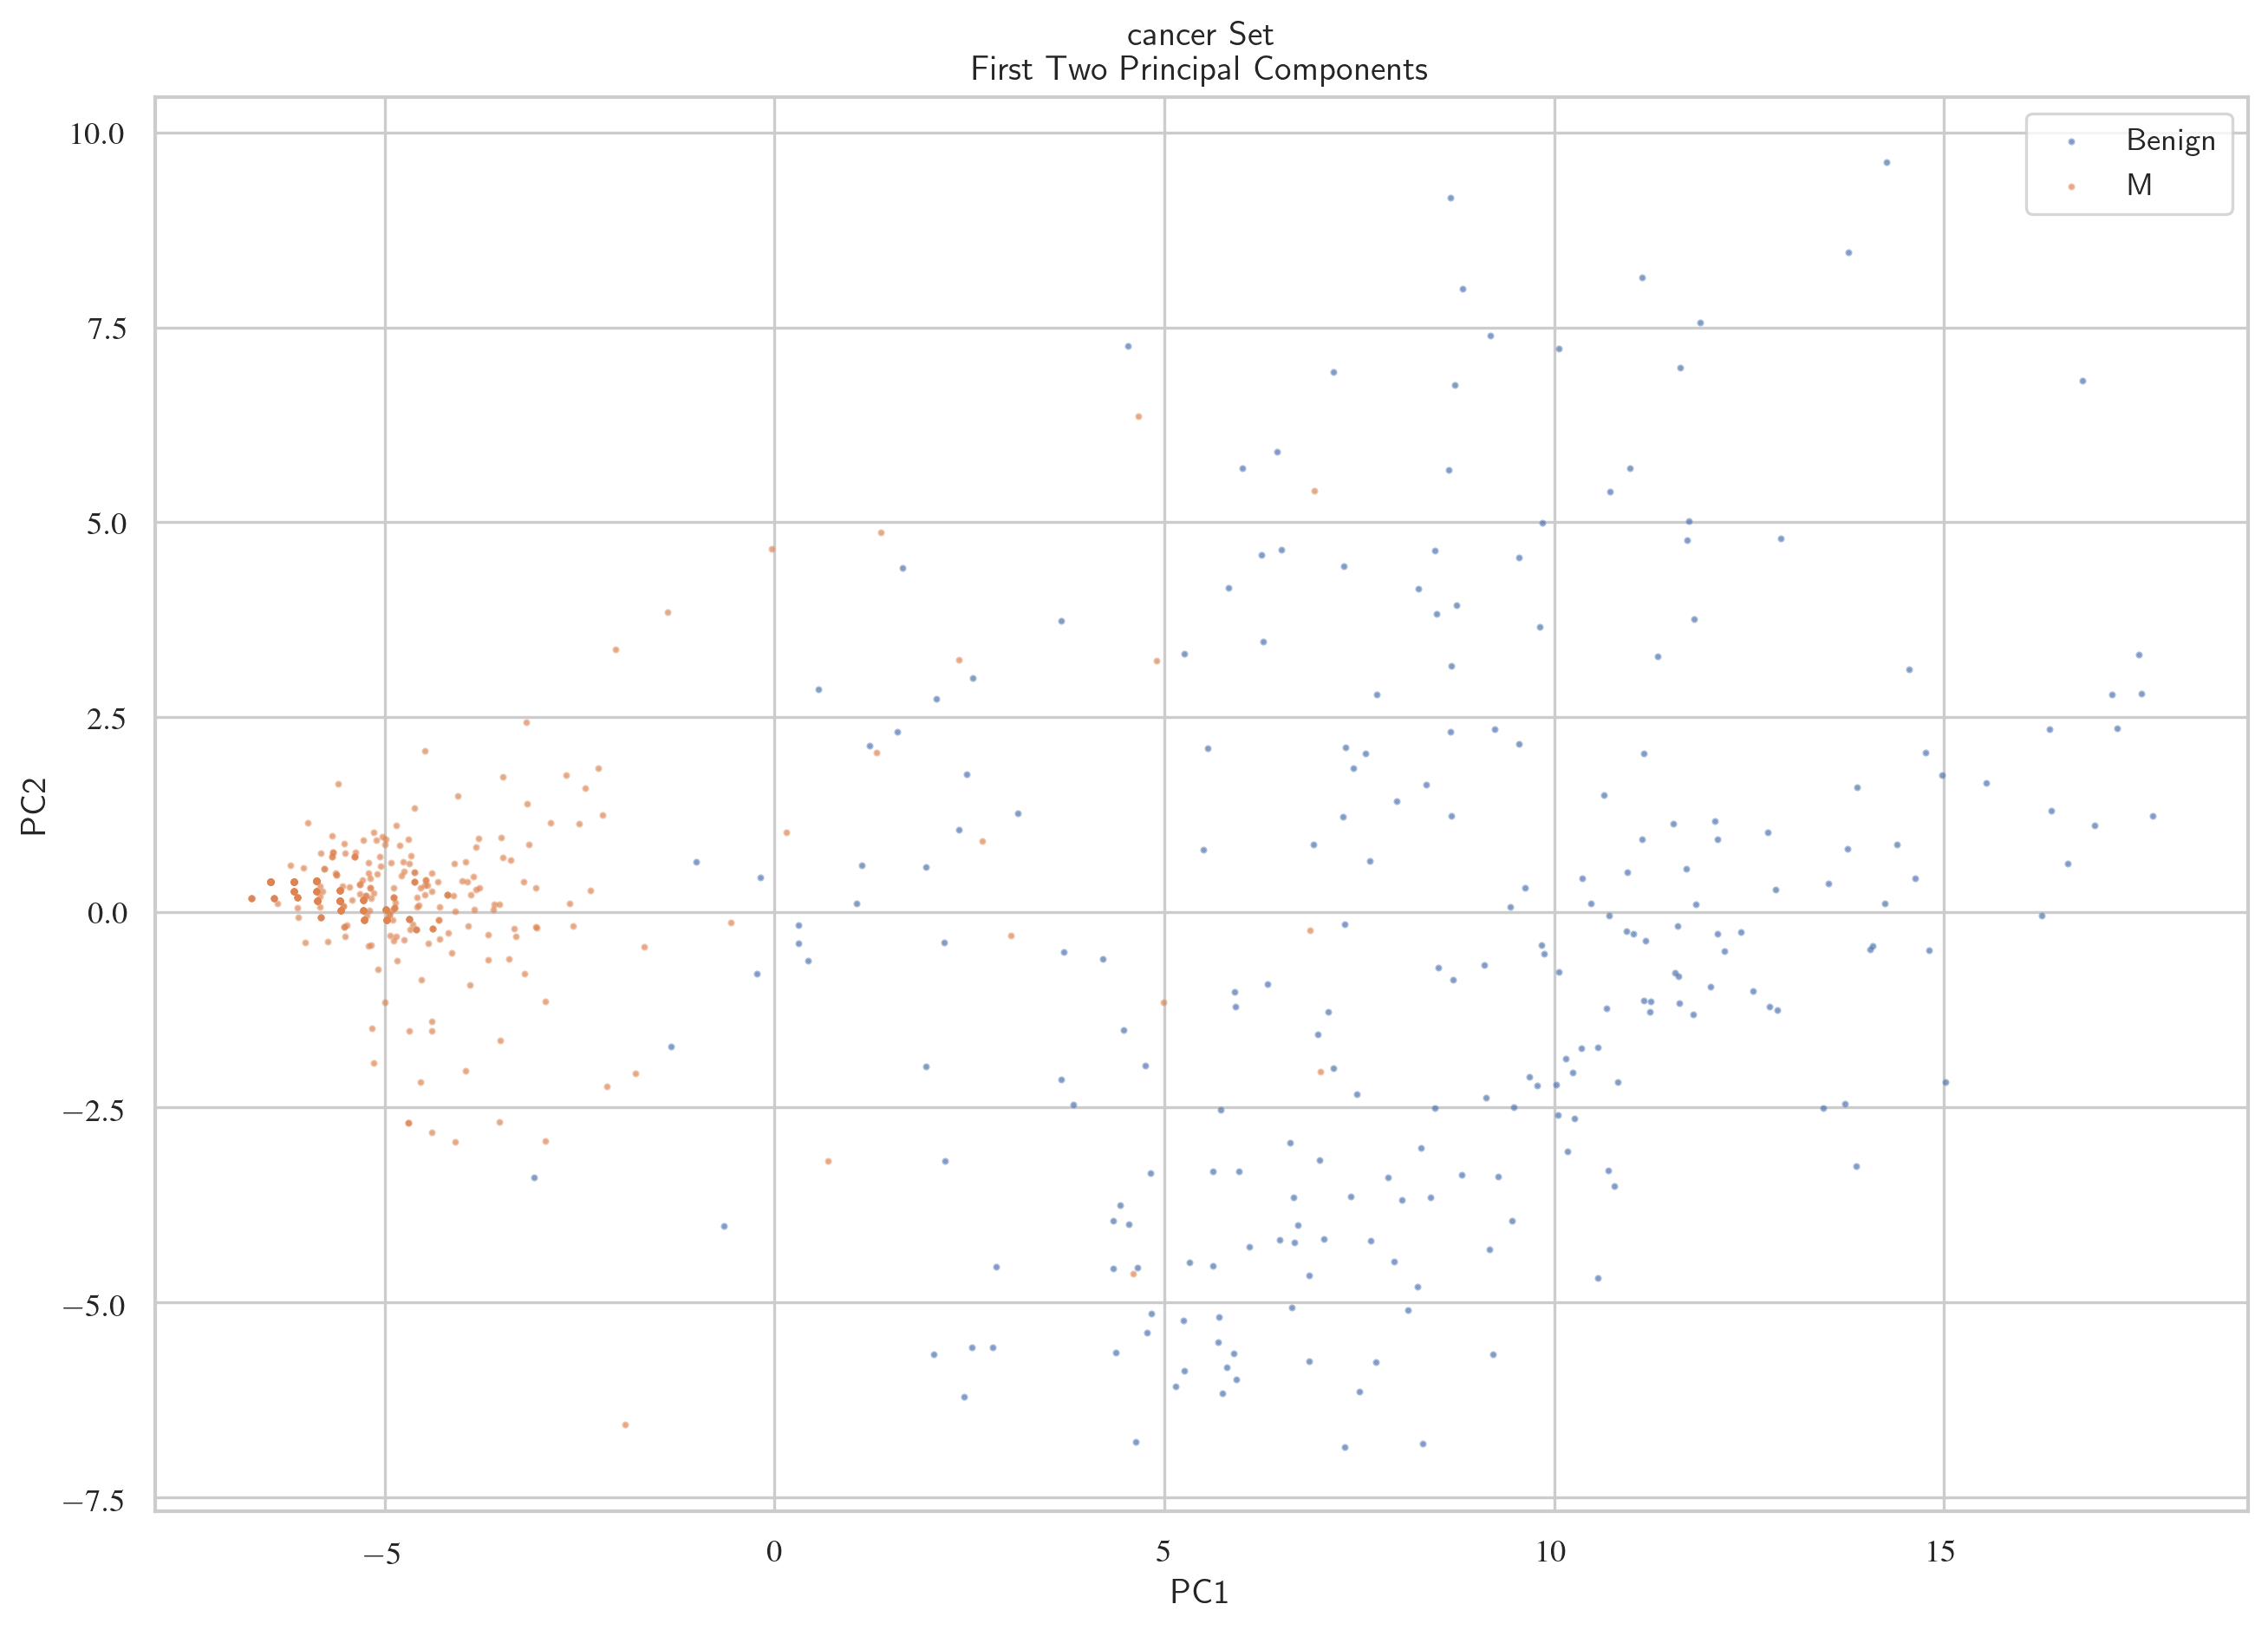

In [390]:

plt.figure(dpi=120)
plt.scatter(pca[Y.values==0,0], pca[Y.values==0,1], alpha=0.5, label='Benign', s=2)
plt.scatter(pca[Y.values==1,0], pca[Y.values==1,1], alpha=0.5, label='M', s=2)
plt.legend()
plt.title('cancer Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')

In [391]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca, Y, random_state=0, test_size=0.3)

In [399]:
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

In [404]:
len(y_test_pca[y_test_pca==1]), len(y_test_pca[y_test_pca==0])

(115, 78)

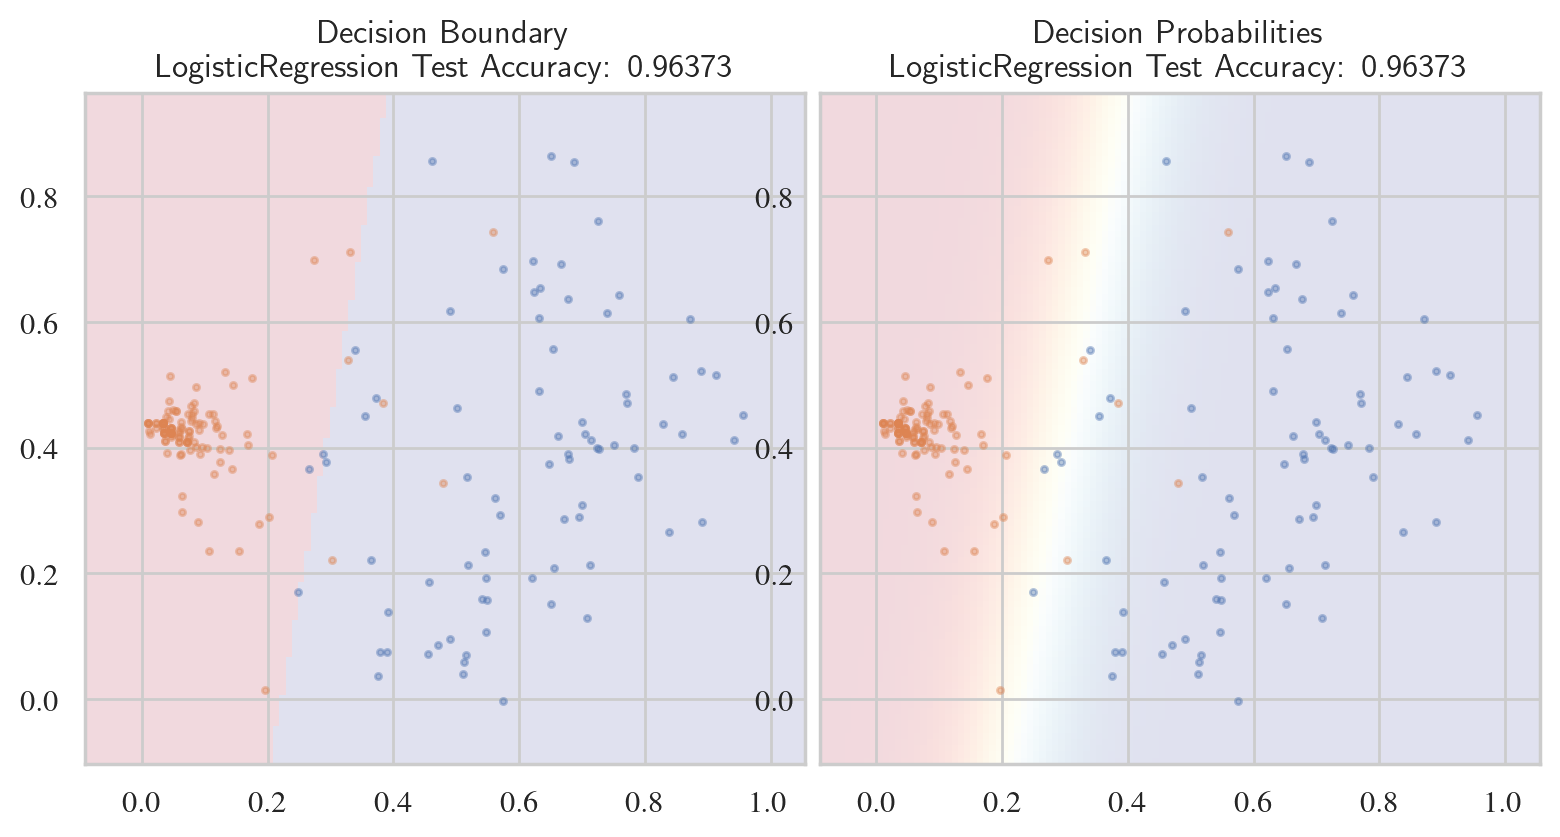

In [406]:
w2 = {0:115/78., 1: 1}
clf_pca_l1 = LogisticRegression(penalty='l1', C=100, solver='liblinear', class_weight=w2).fit(X_train_pca_scaled, y_train_pca)
plot_boundary(X_test_pca_scaled, y_test_pca, clf_pca_l1)

## RF + RFE


In [419]:
from sklearn.ensemble import RandomForestClassifier

In [420]:
# ---------- RF Training ----------
def GridSearch_RFC(X, y, max_features=None,
                   max_depth_max=7, max_depth_min=3,
                   n_estimators=[10, 20, 100, 1000],
                   cv=5, verbose=0, n_jobs=-1,
                  scoring='f1'):

    """
    Parameters
    ----------
    max_features: list
         size of the random subsets of features to consider when splitting a node
    scoring: str
        http://gael-varoquaux.info/interpreting_ml_tuto/content/metrics.html
    """

    if max_features is None:
        max_features = list(max_features)

    from sklearn.model_selection import GridSearchCV, KFold
    cvmethod = KFold(n_splits=cv, shuffle=True)
    gsc = GridSearchCV(
                    estimator=RandomForestClassifier(),
                    param_grid={
                                'max_depth': range(max_depth_min, max_depth_max),
                                'n_estimators': n_estimators,
                                # 'min_samples_leaf': [1, 2, 3],
                                # 'min_samples_split': [4, 5, 6],
                                'max_features': max_features
                    },
        cv=cvmethod,
        scoring=scoring,
        verbose=verbose,
        n_jobs=n_jobs,
        return_train_score=True)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    return gsc, grid_result, best_params

In [448]:
# https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

def get_feature_importance_RF(X_train, y_train, feat_labels, max_features=None, max_depth=5,
                              n_estimators=10, n_jobs=5, cv=10, random_state=0,
                              kfoldCVscoring='f1',
                              nshuffleSplit=5, plot=False):
    """
    Get the imporance of the features using RF Regressor.

    Parameters
    ----------
    max_features: list
         size of the random subsets of features to consider when splitting a node
         https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

    kfoldCVscoring: str
        or 'r2', etc
        should be one where the higher is the better (i.e., if it's a loss, then should be negated)

    NOTE
    ----
    The main thing to avoid is overfitting, so the depth of tree(s) should be relatively small,
    and cross-validation should be applied.

    Firstly, feature selection based on impurity reduction is biased towards preferring variables
    with more categories (see Bias in random forest variable importance measures).
    Secondly, when the dataset has two (or more) correlated features, then
    from the point of view of the model, any of these correlated features can be used
    as the predictor, with no concrete preference of one over the others.
    But once one of them is used, the importance of others is significantly reduced
    since effectively the impurity they can remove is already removed by the first feature.
    As a consequence, they will have a lower reported importance.

    This is not an issue when we want to use feature selection to reduce overfitting,
    since it makes sense to remove features that are mostly duplicated by other features.
    But when interpreting the data, it can lead to the incorrect conclusion that
    one of the variables is a strong predictor while the others in the same group are unimportant,
    while actually they are very close in terms of their relationship with the response variable.
    """
    from sklearn.model_selection import cross_val_score

    if max_features is None:
        max_features = list(max_features)

    print("Running random forest to get the feature imporance with the paramers.. n_estimators:{} random_state :{} \
           max_depth :{} n_jobs :{}".format(
                                            n_estimators, random_state, max_depth, n_jobs))

    forest = RandomForestClassifier(max_features=max_features,
                                   n_estimators=n_estimators,
                                   random_state=random_state,
                                   max_depth=max_depth,
                                   n_jobs=n_jobs)

    forest.fit(X_train, y_train)
    importances = forest.feature_importances_  # get the feature importance

    # get index correspoding to significance from high to low
    indices = np.argsort(importances)[::-1]

    print("Features sorted by their score:")
    for f in range(len(feat_labels)):
        print("%2d) %-*s %f" % (f + 1, 30,
                                feat_labels[indices[f]],
                                importances[indices[f]]))
    # group them and sort them
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feat_labels, importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    if plot:
        # Plot the feature importance in the bar chart.
        plt.close('all')
        plt.figure()
        plt.title("Feature Importance")
        plt.bar(range(len(feat_labels)), importances[indices],
                color='lightblue', align='center')
        plt.xticks(range(len(feat_labels)), np.array(
            feat_labels)[indices], rotation=90)
        plt.xlim([-1, len(feat_labels)])
        plt.tight_layout()
        plt.show()

    # Perform K-Fold CV
    scores_I = cross_val_score(forest, X_train, y_train,
                               cv=cv,
                               scoring=kfoldCVscoring)
    print("Standard K-Fold CV Score, using {:} as metric: ".format(kfoldCVscoring))
    print(scores_I)

    return forest, feature_importances, scores_I

In [424]:
cvmethod = KFold(n_splits=25, shuffle=True)

rfr = RandomForestClassifier()
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[1, 5, 10, 15, 20],
#                    'min_samples_leaf': [1, 2, 4],
#                    'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.logspace(1, 2, 3)]
                   }
rf_random = RandomizedSearchCV(rfr, hyperparameters, n_iter=10, 
                               cv=cvmethod,
                               verbose=2, random_state=123, n_jobs=-1,
                              )
rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print(best_params)
print(rf_random.best_score_)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.2s finished


RandomizedSearchCV(cv=KFold(n_splits=25, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                            

{'n_estimators': 31, 'max_features': 'auto', 'max_depth': 20}
0.9733333333333334


In [427]:
# Specify a narrower range of hyperparameters for fine-tuning, based on RandomizedSearchCV()
gsc, grid_result, best_params = GridSearch_RFC(X_train, y_train,
                                               max_features=['auto'],
                                               max_depth_max=int(best_params['max_depth']+1),
                                               max_depth_min=int(best_params['max_depth']-1),
                                               n_estimators=[int(np.floor(0.8*best_params['n_estimators'])),
                                                               best_params['n_estimators'],
                                                             int(np.ceil(1.2*best_params['n_estimators']))],
                            verbose=1, scoring='f1')
# NOTE the best hyperparameter will depend on the scoring metric used
gsc.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sc

In [428]:
grid_result.best_score_
scores_df = pd.DataFrame(gsc.cv_results_)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 100 #Another acceptable syntax
scores_df[['params', 'mean_test_score', 'mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

0.9792854562320634

,params,mean_test_score,mean_train_score,mean_fit_time
0,"{'max_depth': 18, 'max_features': 'auto', 'n_estimators': 24}",0.979285,0.997856,0.054157
5,"{'max_depth': 19, 'max_features': 'auto', 'n_estimators': 38}",0.975584,1.000000,0.097945
2,"{'max_depth': 18, 'max_features': 'auto', 'n_estimators': 38}",0.975472,0.999577,0.117981
4,"{'max_depth': 19, 'max_features': 'auto', 'n_estimators': 31}",0.970561,0.999579,0.091110
3,"{'max_depth': 19, 'max_features': 'auto', 'n_estimators': 24}",0.970421,0.997892,0.085342
1,"{'max_depth': 18, 'max_features': 'auto', 'n_estimators': 31}",0.970353,1.000000,0.082945


In [441]:
forest, feature_importances, s1 = get_feature_importance_RF(X_train, y_train,
                          feat_labels=X_train.columns,
                          max_features=gsc.best_params_['max_features'],
                          max_depth=gsc.best_params_["max_depth"],
                          n_estimators=gsc.best_params_["n_estimators"],
                          n_jobs=-1)

Running random forest to get the feature imporance with the paramers.. n_estimators:24 random_state :0            max_depth :18 n_jobs :-1
Features sorted by their score:
 1) uniformityofcellsize           0.316159
 2) barenuclei                     0.158799
 3) uniformityofcellshape          0.126125
 4) blandchromatin                 0.119090
 5) singleepithelialcellsize       0.102128
 6) clumpthickness                 0.078297
 7) normalnucleoli                 0.051304
 8) marginaladhesion               0.029462
 9) mitoses                        0.018636
Standard K-Fold CV Score, using f1 as metric: 
[0.98305085 1.         1.         0.95081967 1.         0.98245614
 0.93103448 0.98245614 0.98245614 0.96428571]
[(1.0, 'singleepithelialcellsize'), (0.96, 'uniformityofcellshape'), (0.96, 'blandchromatin'), (0.96, 'barenuclei'), (0.933, 'normalnucleoli'), (0.933, 'marginaladhesion'), (0.893, 'uniformityofcellsize'), (0.793, 'mitoses'), (0.733, 'clumpthickness')]


([<matplotlib.axis.XTick at 0x7fca4da2c790>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Variable')

Text(0, 0.5, 'Cumulative Importance')

Text(0.5, 1.0, 'Cumulative Importances')

Number of features for 95% importance: 7


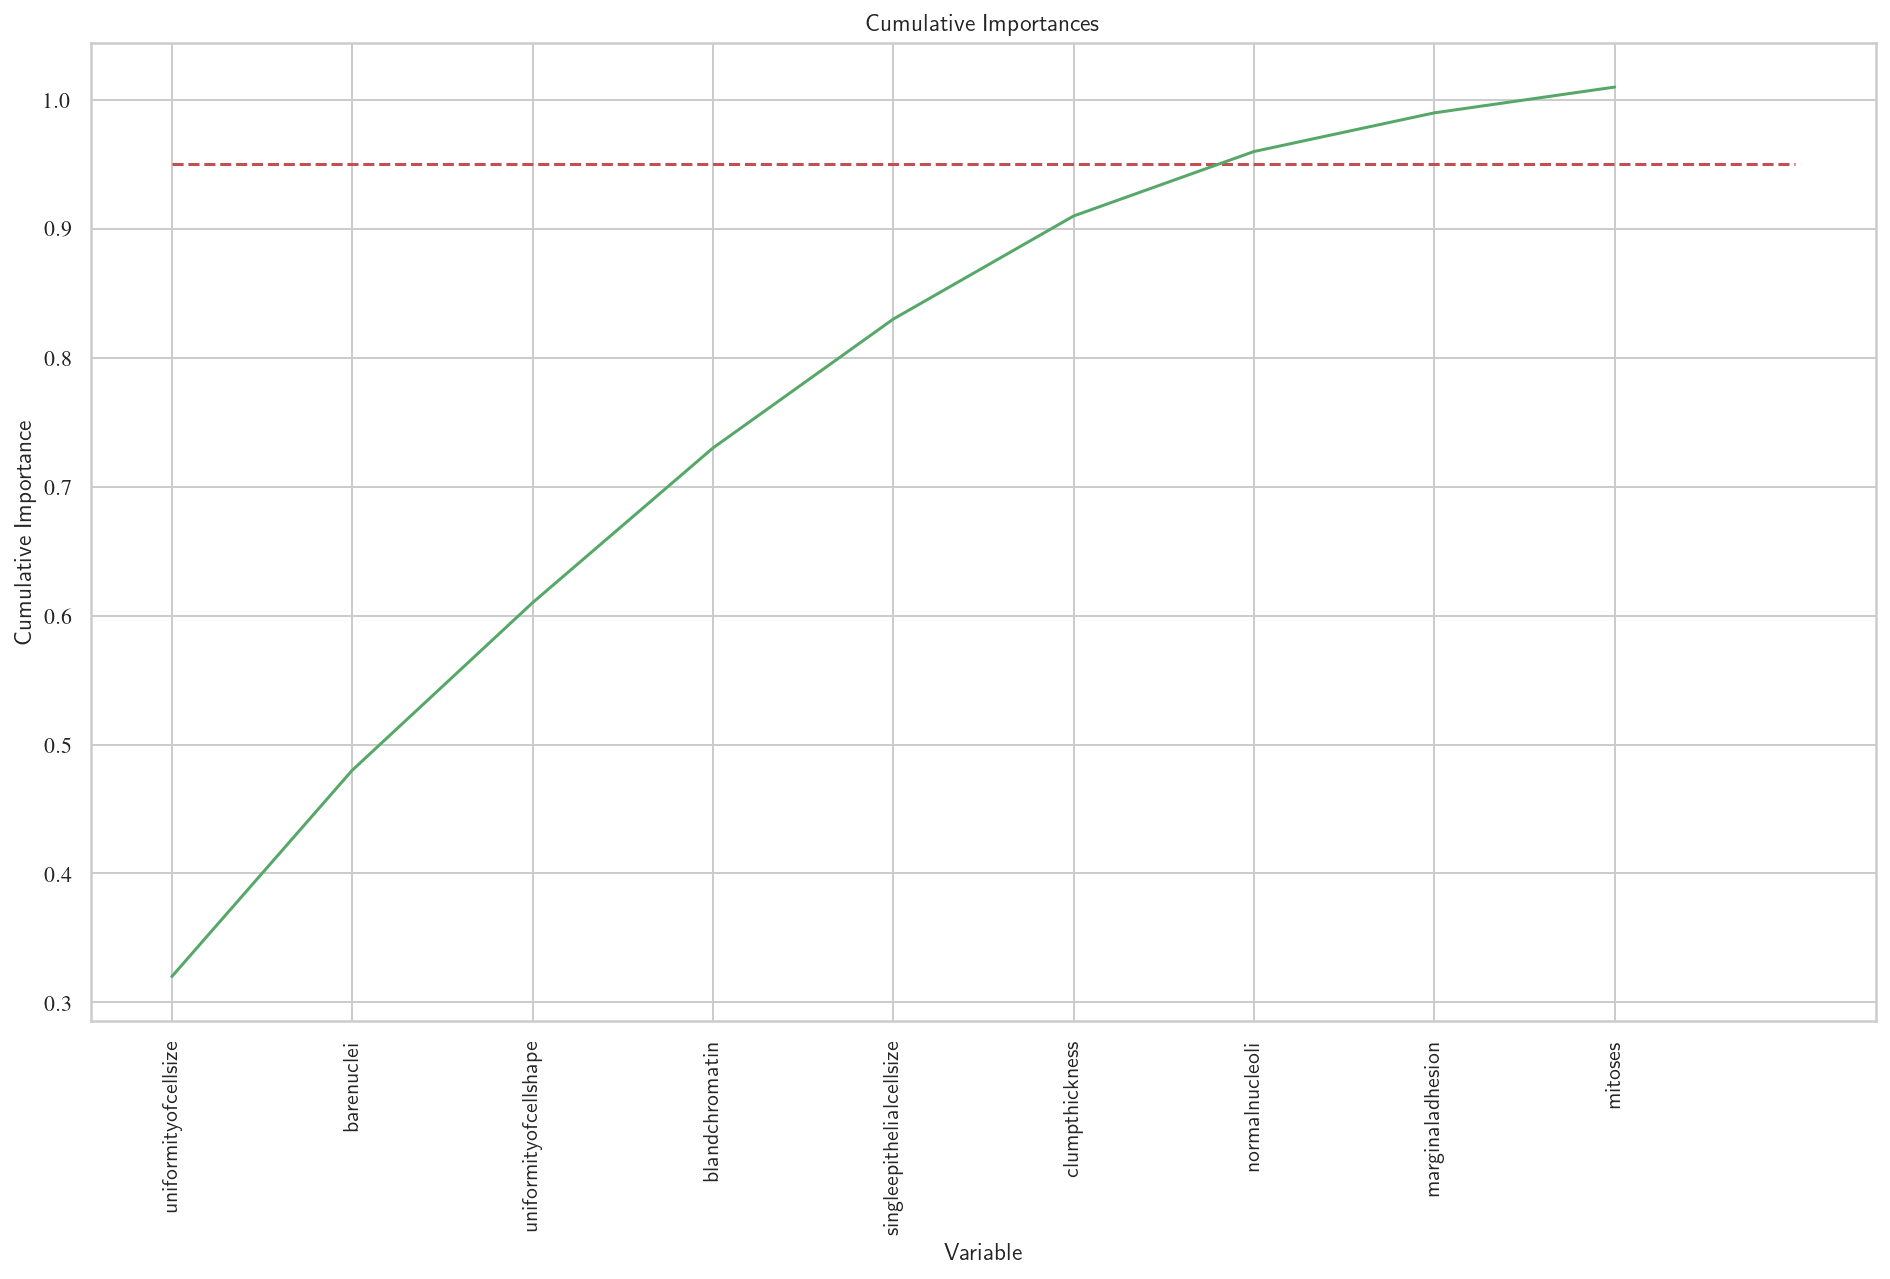

In [442]:
# make a cumulative importance graph that shows the contribution to
# the overall importance of each additional variable. The dashed line
# is drawn at 95% of total importance accounted for.

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
x_values = list(range(len(feature_importances)))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y=0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation='vertical')
plt.xlabel('Variable');
plt.ylabel('Cumulative Importance');
plt.title('Cumulative Importances');

# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

In [445]:
#
# Permutation feature importance: a kind of feature selection method complementary to RFC
# (see also https://explained.ai/rf-importance/index.html)
#
# Instead of fitting RFC, here we directly measure the impact of each feature on accuracy of the model.
# The general idea is to permute the values of each feature and
# measure how much the permutation decreases the accuracy of the model.
# For unimportant variables, the permutation should have little to no effect on model accuracy,
# while permuting important variables should significantly decrease it.
#
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [447]:
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           max_features=best_params['max_features']
                          )

model = rf.fit(X_train, y_train)
perm = PermutationImportance(rf, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.values)


Weight,Feature
0.0427 ± 0.0158,barenuclei
0.0138 ± 0.0044,uniformityofcellshape
0.0089 ± 0.0049,clumpthickness
0.0089 ± 0.0028,marginaladhesion
0.0076 ± 0.0022,singleepithelialcellsize
0.0076 ± 0.0036,uniformityofcellsize
0.0067 ± 0.0049,blandchromatin
0.0062 ± 0.0052,normalnucleoli
0.0004 ± 0.0018,mitoses


# Conaclusions and Next Steps
Summarize findings here

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li><li><span><a href="#missing-data" data-toc-modified-id="missing-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>missing data</a></span></li><li><span><a href="#Impute-using-mode-of-each-class" data-toc-modified-id="Impute-using-mode-of-each-class-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Impute using mode of each class</a></span></li><li><span><a href="#save-cleaned-data" data-toc-modified-id="save-cleaned-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>save cleaned data</a></span></li><li><span><a href="#any-imbalance-in-class?" data-toc-modified-id="any-imbalance-in-class?-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>any imbalance in class?</a></span></li><li><span><a href="#Split-into-features-X-and-label-Y" data-toc-modified-id="Split-into-features-X-and-label-Y-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Split into features X and label Y</a></span></li></ul></li><li><span><a href="#Analysis/Modeling---Classification,-feature-importance" data-toc-modified-id="Analysis/Modeling---Classification,-feature-importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis/Modeling - Classification, feature importance</a></span><ul class="toc-item"><li><span><a href="#LR" data-toc-modified-id="LR-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LR</a></span></li><li><span><a href="#Final-model-for-LR" data-toc-modified-id="Final-model-for-LR-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Final model for LR</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ROC curve</a></span></li><li><span><a href="#PR-curve" data-toc-modified-id="PR-curve-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PR curve</a></span></li><li><span><a href="#feature-selection" data-toc-modified-id="feature-selection-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>feature selection</a></span></li><li><span><a href="#Visualize:-PCA-+-DB" data-toc-modified-id="Visualize:-PCA-+-DB-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Visualize: PCA + DB</a></span></li><li><span><a href="#RF-+-RFE" data-toc-modified-id="RF-+-RFE-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>RF + RFE</a></span></li></ul></li><li><span><a href="#Conaclusions-and-Next-Steps" data-toc-modified-id="Conaclusions-and-Next-Steps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conaclusions and Next Steps</a></span></li></ul></div>